07.02.23

# Analyse slices annotated by experts

- Open, organise and analyse the slices that have been annotated by the experts.
- Compute some metrics to get inter-observer variability

Author: Prisca Dotti  
Last modified: 26.10.2023

In [1]:
# autoreload is used to reload modules automatically before entering the
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2
# To import modules from parent directory in Jupyter Notebook
import sys
sys.path.append("..")

In [4]:
import numpy as np

# import glob
import os
import imageio
import warnings

import math
import seaborn as sns
import pandas as pd
import scipy
from scipy.stats import kruskal
from sklearn.metrics import cohen_kappa_score
import scikit_posthocs as sp
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters

# from skimage.io import imsave

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from data.data_processing_tools import (
    process_raw_predictions,
    preds_dict_to_mask,
    one_sided_non_inferiority_ttest,
)
from utils.in_out_tools import load_movies_ids

# set up matplotlib parameters so that .svg can correctly be processed in illustrator
import matplotlib

matplotlib.rcParams["svg.fonttype"] = "none"

## Load slices annotated by experts

In [8]:
slices_ids = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10"]
expert_ids = ["RJ", "ME", "EN", "NS", "MW", "CS"]

# make expert ids anonymous
anon_ids = {expert_id: "expert_" + str(i)
            for i, expert_id in enumerate(expert_ids)}
anon_ids_list = list(anon_ids.values())


annotations_dir = r"C:\Users\dotti\OneDrive - Universitaet Bern\inter-rater_variability\annotated_slices"

In [6]:
# Load all .tif files and save them in a dictionary
# Dictionary are indexed by the slice id and the expert id
all_segmentations = dict.fromkeys(
    anon_ids_list + ["ground_truth", "unet_preds"])

In [9]:
for expert_id in expert_ids:
    all_segmentations[anon_ids[expert_id]] = dict.fromkeys(slices_ids)
    for slice_id in slices_ids:
        all_segmentations[anon_ids[expert_id]][slice_id] = imageio.volread(
            os.path.join(annotations_dir, expert_id,
                         "sample" + slice_id + ".tif")
        )

## Load corresponding slices in annotated dataset and UNet predictions

In [10]:
slice_to_movie_id = {
    "01": "15",
    "02": "20",
    "03": "34",
    "04": "05",
    "05": "10",
    "06": "25",
    "07": "32",
    "08": "34",
    "09": "40",
    "10": "45",
}

slice_to_frame_id = {
    "01": 54 - 1,
    "02": 445 - 1,
    "03": 430 - 1,
    "04": 351 - 1,
    "05": 410 - 1,
    "06": 109 - 1,
    "07": 950 - 1,
    "08": 894 - 1,
    "09": 898 - 1,
    "10": 667 - 1,
}

### Load annotated dataset

In [11]:
dataset_dir = os.path.join("..", "data", "sparks_dataset")

In [12]:
all_segmentations["ground_truth"] = dict.fromkeys(slices_ids)
for slice_id in slices_ids:
    movie_id = slice_to_movie_id[slice_id]
    frame_id = slice_to_frame_id[slice_id]
    all_segmentations["ground_truth"][slice_id] = np.asarray(
        imageio.volread(os.path.join(
            dataset_dir, (movie_id + "_class_label.tif")))
    )[frame_id]

### Load predicted segmentation

In [13]:
movie_ids = ["05", "10", "15", "20", "25", "32", "34", "40", "45"]

In [14]:
# training_name = 'TEMP_new_annotated_peaks_physio_2'
training_name = "final_model"
epoch = 100000
inference_mode = "overlap"

preds_dir = os.path.join(
    "..", "evaluation", "inference_script", training_name, f"inference_{inference_mode}"
)

In [15]:
### Load movies
input_movies = load_movies_ids(
    data_folder=dataset_dir, ids=movie_ids, names_available=True, movie_names="video"
)

### Load predictions
sparks_filenames = {
    movie_id: os.path.join(
        preds_dir,
        f"{training_name}_{epoch}_{movie_id}_{inference_mode}_segmented_sparks.tif",
    )
    for movie_id in movie_ids
}
puffs_filenames = {
    movie_id: os.path.join(
        preds_dir,
        f"{training_name}_{epoch}_{movie_id}_{inference_mode}_segmented_puffs.tif",
    )
    for movie_id in movie_ids
}
waves_filenames = {
    movie_id: os.path.join(
        preds_dir,
        f"{training_name}_{epoch}_{movie_id}_{inference_mode}_segmented_waves.tif",
    )
    for movie_id in movie_ids
}

sparks = {
    movie_id: np.asarray(imageio.volread(f)) for movie_id, f in sparks_filenames.items()
}
puffs = {
    movie_id: np.asarray(imageio.volread(f)) for movie_id, f in puffs_filenames.items()
}
waves = {
    movie_id: np.asarray(imageio.volread(f)) for movie_id, f in waves_filenames.items()
}

In [19]:
preds_segmentation = {}

for movie_id in movie_ids:
    preds_dict = {
        "sparks": sparks[movie_id],
        "puffs": puffs[movie_id],
        "waves": waves[movie_id],
    }
    preds_segmentation[movie_id] = preds_dict_to_mask(preds_dict)

In [25]:
all_segmentations["unet_preds"] = dict.fromkeys(slices_ids)
for slice_id in slices_ids:
    movie_id = slice_to_movie_id[slice_id]
    frame_id = slice_to_frame_id[slice_id]
    all_segmentations["unet_preds"][slice_id] = preds_segmentation[movie_id][frame_id]

In [26]:
for slice_id in slices_ids:
    for annotator in all_segmentations.keys():
        print(
            f"Slice {slice_id} - {annotator}: {np.unique(all_segmentations[annotator][slice_id])}"
        )

Slice 01 - expert_0: [0 3]
Slice 01 - expert_1: [0 3]
Slice 01 - expert_2: [0 3]
Slice 01 - expert_3: [0 1]
Slice 01 - expert_4: [0 3]
Slice 01 - expert_5: [0 3]
Slice 01 - ground_truth: [0 1 3]
Slice 01 - unet_preds: [0 3]
Slice 02 - expert_0: [0 1 3]
Slice 02 - expert_1: [0 1 3]
Slice 02 - expert_2: [0 1 2]
Slice 02 - expert_3: [0 2 3]
Slice 02 - expert_4: [0 1 3]
Slice 02 - expert_5: [0 1]
Slice 02 - ground_truth: [0 3]
Slice 02 - unet_preds: [0 1 3]
Slice 03 - expert_0: [0 1]
Slice 03 - expert_1: [0 1 3]
Slice 03 - expert_2: [0 1 3]
Slice 03 - expert_3: [0 1]
Slice 03 - expert_4: [0 1 3]
Slice 03 - expert_5: [0 1 3]
Slice 03 - ground_truth: [0 1 2]
Slice 03 - unet_preds: [0 1]
Slice 04 - expert_0: [0 1 3]
Slice 04 - expert_1: [0 1 3]
Slice 04 - expert_2: [0 1 3]
Slice 04 - expert_3: [0 1 3]
Slice 04 - expert_4: [0 1 3]
Slice 04 - expert_5: [0 1 3]
Slice 04 - ground_truth: [0 1 3]
Slice 04 - unet_preds: [0 1 3]
Slice 05 - expert_0: [0 3]
Slice 05 - expert_1: [0 3]
Slice 05 - expert_

In [27]:
all_segmentations.keys()

dict_keys(['expert_0', 'expert_1', 'expert_2', 'expert_3', 'expert_4', 'expert_5', 'ground_truth', 'unet_preds'])

In [30]:
warnings.filterwarnings("ignore")
# for each slice ID, compute inter-annotator agreement and store results in a dataframe
kappa_list = []
for slice_id in slices_ids:
    # get mask of pixels ignored during training
    ignore_mask = (all_segmentations["ground_truth"][slice_id] == 4).flatten()

    for annotator_1 in all_segmentations.keys():
        for annotator_2 in all_segmentations.keys():
            if annotator_1 != annotator_2:
                # print(f"A1: {annotator_1} - A2: {annotator_2} - Slice: {slice_id}")

                # compute jaccaard similarity for each class
                # jaccard_0, jaccard_1, jaccard_2, jaccard_3 = jaccard_score(all_segmentations[annotator_1][slice_id].flatten(),
                #                                                         all_segmentations[annotator_2][slice_id].flatten(),
                #                                                         labels=[0,1,2,3],
                #                                                         average=None)
                # jaccard_average = np.mean([jaccard_1, jaccard_2, jaccard_3])

                kappa_list.append(
                    {
                        "slice_id": slice_id,
                        "annotator_1": annotator_1,
                        "annotator_2": annotator_2,
                        "kappa": cohen_kappa_score(
                            all_segmentations[annotator_1][slice_id].flatten(),
                            all_segmentations[annotator_2][slice_id].flatten(),
                            labels=[0, 1, 2, 3],
                        ),
                        # 'jaccard_sparks': jaccard_1,
                        # 'jaccard_puffs': jaccard_2,
                        # 'jaccard_waves': jaccard_3,
                        # 'jaccard_average': jaccard_average
                    }
                )

kappa_df = pd.DataFrame(kappa_list)

warnings.filterwarnings("default")

In [31]:
# remove entries in kappa_df where annotator_1 == ground_truth or annotator_2 == ground_truth
kappa_df_no_gt = kappa_df[
    (kappa_df.annotator_1 != "ground_truth") & (
        kappa_df.annotator_2 != "ground_truth")
]

# remove entries in kappa_df where annotator_1 == unet_preds or annotator_2 == unet_preds
kappa_df_no_preds = kappa_df[
    (kappa_df.annotator_1 != "unet_preds") & (
        kappa_df.annotator_2 != "unet_preds")
]

In [32]:
kappa_df

slice_id annotator_1   annotator_2     kappa
0         01    expert_0      expert_1  0.796058
1         01    expert_0      expert_2  0.253748
2         01    expert_0      expert_3  0.116472
3         01    expert_0      expert_4  0.604320
4         01    expert_0      expert_5  0.440630
..       ...         ...           ...       ...
555       10  unet_preds      expert_2  0.846019
556       10  unet_preds      expert_3  0.729666
557       10  unet_preds      expert_4  0.830864
558       10  unet_preds      expert_5  0.810145
559       10  unet_preds  ground_truth  0.631392

[560 rows x 4 columns]

In [33]:
kappa_df

slice_id annotator_1   annotator_2     kappa
0         01    expert_0      expert_1  0.796058
1         01    expert_0      expert_2  0.253748
2         01    expert_0      expert_3  0.116472
3         01    expert_0      expert_4  0.604320
4         01    expert_0      expert_5  0.440630
..       ...         ...           ...       ...
555       10  unet_preds      expert_2  0.846019
556       10  unet_preds      expert_3  0.729666
557       10  unet_preds      expert_4  0.830864
558       10  unet_preds      expert_5  0.810145
559       10  unet_preds  ground_truth  0.631392

[560 rows x 4 columns]

In [34]:
PROPS = {
    "boxprops": {"facecolor": "none", "edgecolor": "black"},
    "medianprops": {"color": "black"},
    "whiskerprops": {"color": "black"},
    "capprops": {"color": "black"},
}

In [35]:
# visualize kappa values
plt.figure(figsize=(15, 8))
sns.set_style("ticks")

ax = sns.boxplot(
    x="annotator_1", y="kappa", data=kappa_df, color="1.0", linewidth=1, **PROPS
)

ax = sns.swarmplot(
    x="annotator_1", y="kappa", data=kappa_df, hue="annotator_2", palette="husl"
)  # , size=3)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.title("Expert  vs. all experts and all slices", fontsize=20)

sns.despine()
plt.show()

In [36]:
# VALUTARE SE NE VALE LA PENA -> se caso plot da aggiornare
# visualize jaccard_average values
# plt.figure(figsize=(15,8))
# sns.set_theme(style="whitegrid")

# ax = sns.boxplot(x="annotator_1", y="jaccard_average", data=kappa_df, palette="Set3")
# ax = sns.swarmplot(x="annotator_1", y="jaccard_average", data=kappa_df, color=".5", size=3)

# plt.title("Expert  vs. all experts and all slices")

# plt.show()

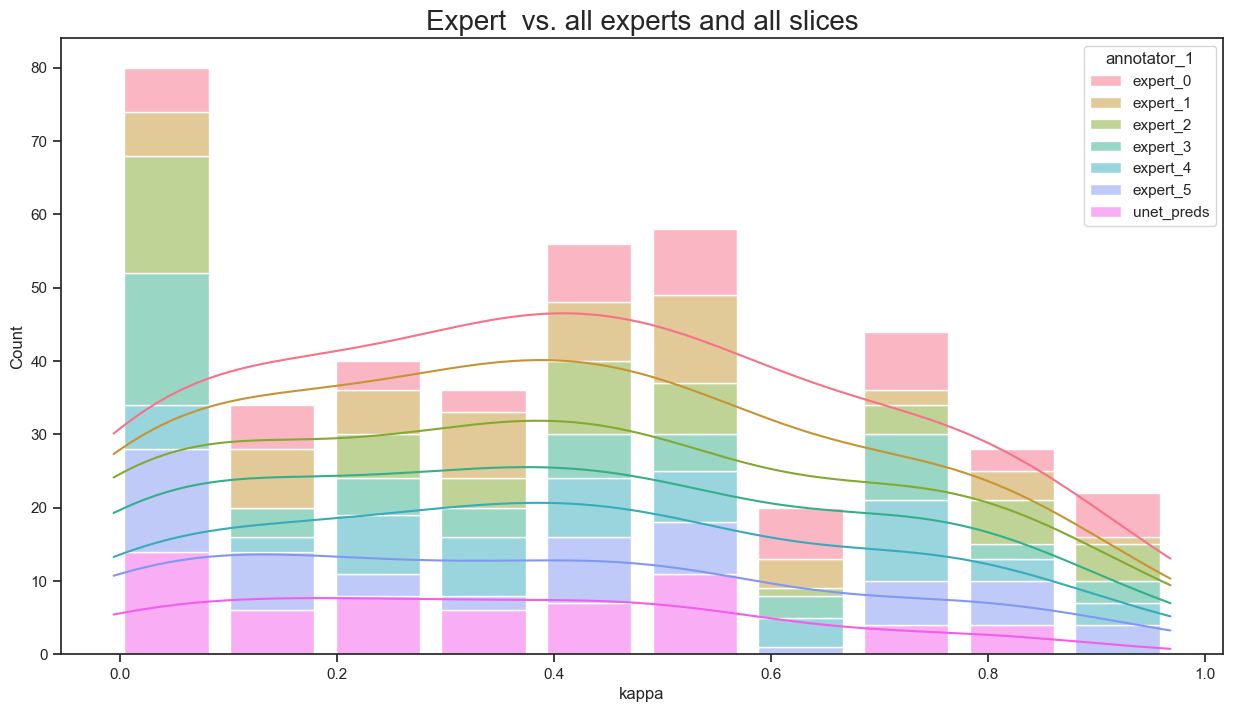

In [39]:
# plot histogram of kappa values --> per vedere se i kappa seguono una distribuzione normale
plt.figure(figsize=(15, 8))
# sns.set_theme(style="whitegrid")
sns.set_style("ticks")

ax = sns.histplot(
    kappa_df_no_gt,
    x="kappa",
    hue="annotator_1",
    multiple="stack",
    palette="husl",
    shrink=0.8,
    kde=True,
)

plt.title("Expert  vs. all experts and all slices", fontsize=20)

plt.show()

Text(0.5, 1.0, 'Expert vs. all experts on each slice')

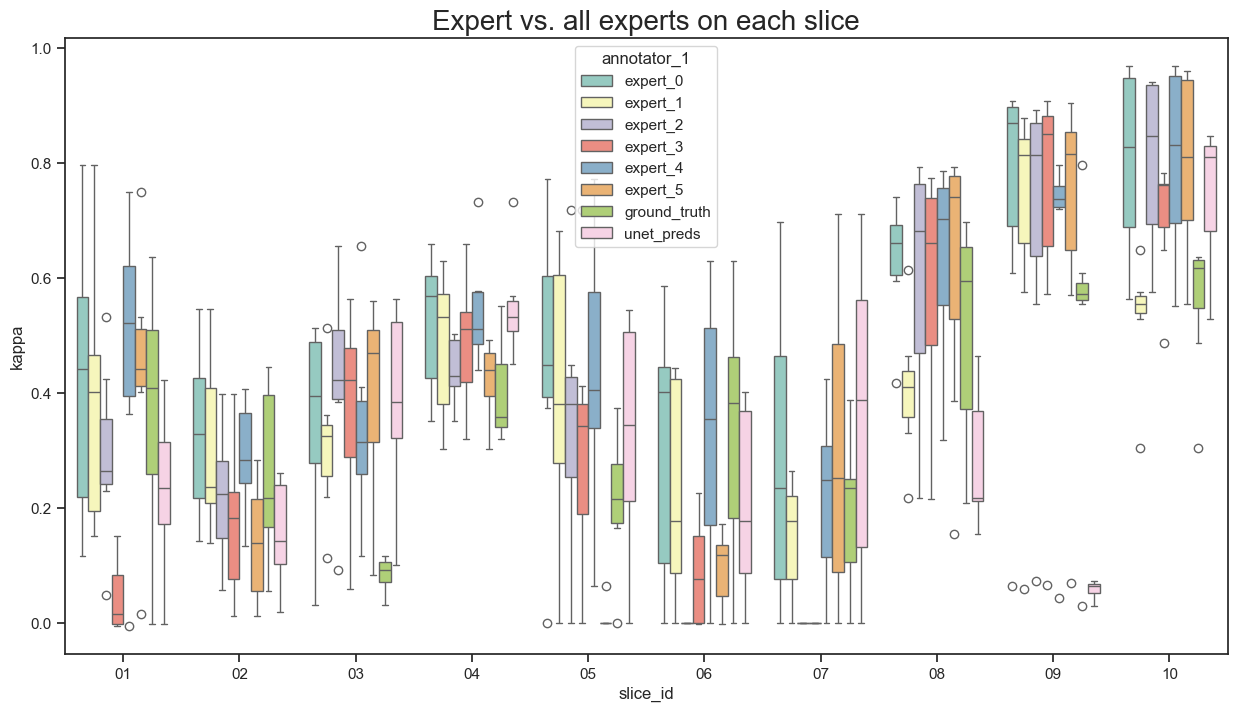

In [40]:
# visualize kappa values for each slice
plt.figure(figsize=(15, 8))
# sns.set_theme(style="whitegrid")
sns.set_style("ticks")

ax = sns.boxplot(
    x="slice_id", y="kappa", hue="annotator_1", data=kappa_df, palette="Set3"
)

plt.title("Expert vs. all experts on each slice", fontsize=20)

In [41]:
# VALUTARE SE NE VALE LA PENA -> se caso plot da aggiornare
# visualize jaccard_average values for each slice
# plt.figure(figsize=(15,8))
# sns.set_theme(style="whitegrid")

# ax = sns.boxplot(x="slice_id", y="jaccard_average", hue="annotator_1", data=kappa_df, palette="Set3")

# plt.title("Expert vs. all experts on each slice")

Text(0.5, 1.0, 'Pairwise comparison of experts on all slices')

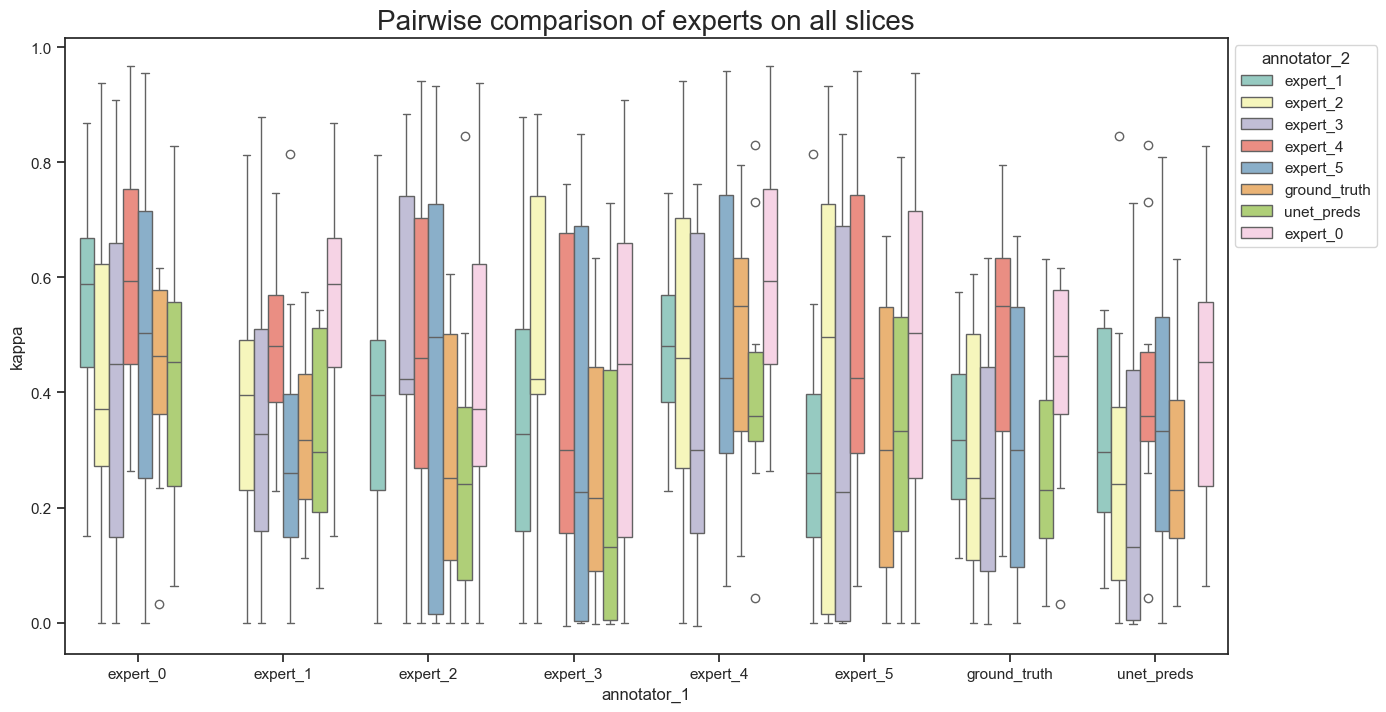

In [42]:
# visualize kappa values for each annotator
plt.figure(figsize=(15, 8))
# sns.set_theme(style="whitegrid")
sns.set_style("ticks")

ax = sns.boxplot(
    x="annotator_1", y="kappa", hue="annotator_2", data=kappa_df, palette="Set3"
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.title("Pairwise comparison of experts on all slices", fontsize=20)

In [43]:
# VALUTARE SE NE VALE LA PENA -> se caso plot da aggiornare
# visualize jaccard_average values for each annotator
# sns.set_theme(style="whitegrid")
# ax = sns.boxplot(x="annotator_1", y="jaccard_average", hue="annotator_2", data=kappa_df)

[Text(0, 0.5, 'Expert 1'),
 Text(0, 1.5, 'Expert 2'),
 Text(0, 2.5, 'Expert 3'),
 Text(0, 3.5, 'Expert 4'),
 Text(0, 4.5, 'Expert 5'),
 Text(0, 5.5, 'Expert 6'),
 Text(0, 6.5, 'Ground Truth'),
 Text(0, 7.5, 'UNet preds')]

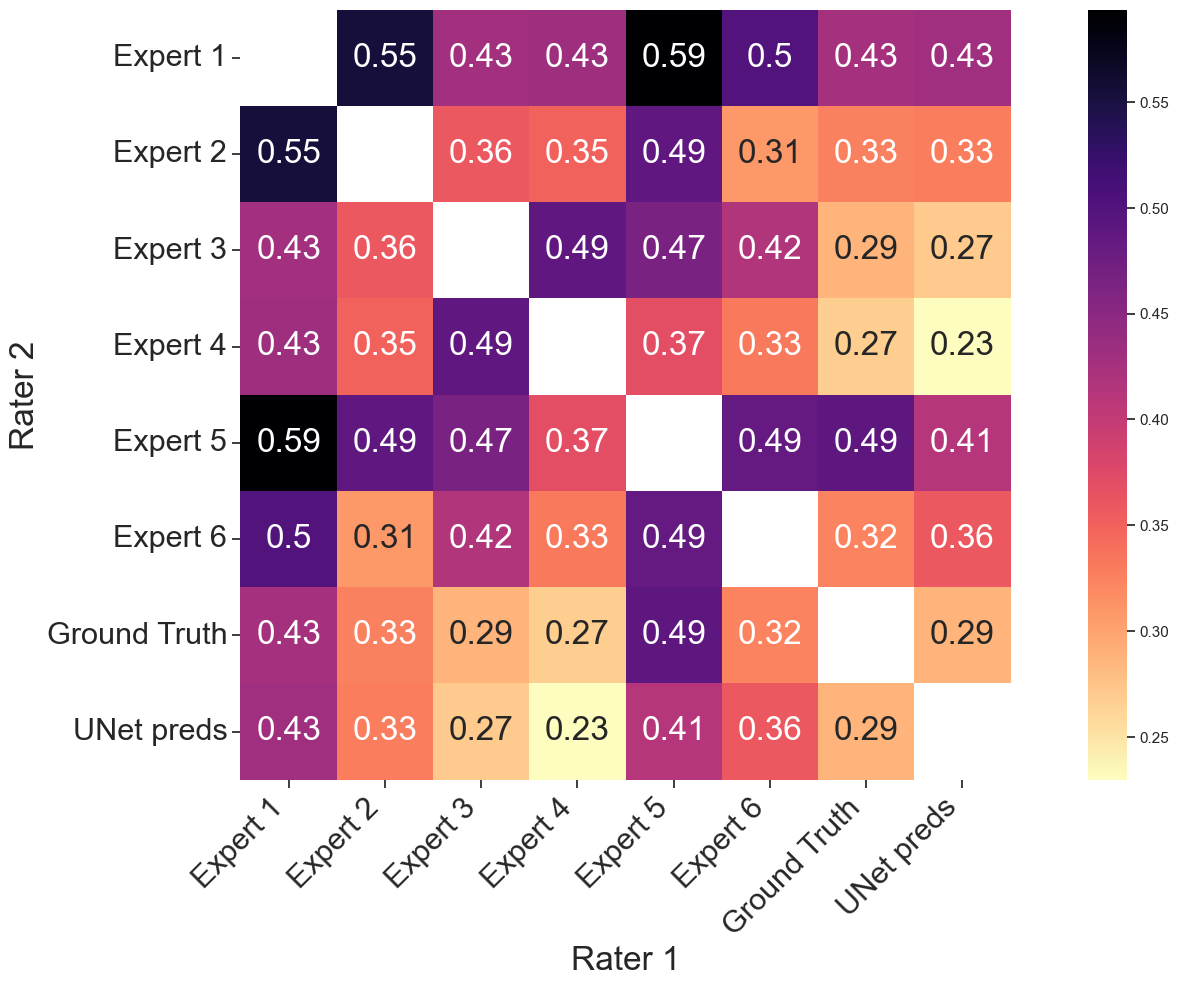

In [44]:
# compute average kappa values over all slices and plot heatmap
sns.set_style("ticks")

avg_kappa_df = kappa_df.pivot_table(
    index="annotator_1", columns="annotator_2", values="kappa", aggfunc="mean"
)


plt.figure(figsize=(20, 10))

ax = sns.heatmap(
    avg_kappa_df,
    annot=True,
    cmap=sns.color_palette("magma_r", as_cmap=True),
    annot_kws={"size": 24},
    square=True,
)
ax.set_xlabel("Rater 1", fontsize=24)
ax.set_ylabel("Rater 2", fontsize=24)

tick_labels = [
    "Expert 1",
    "Expert 2",
    "Expert 3",
    "Expert 4",
    "Expert 5",
    "Expert 6",
    "Ground Truth",
    "UNet preds",
]
ax.set_xticklabels(tick_labels, rotation=45, ha="right", fontsize=22)
ax.set_yticklabels(tick_labels, rotation=0, ha="right", fontsize=22)

[Text(0, 0.5, 'Expert 1'),
 Text(0, 1.5, 'Expert 2'),
 Text(0, 2.5, 'Expert 3'),
 Text(0, 3.5, 'Expert 4'),
 Text(0, 4.5, 'Expert 5'),
 Text(0, 5.5, 'Expert 6'),
 Text(0, 6.5, 'UNet preds')]

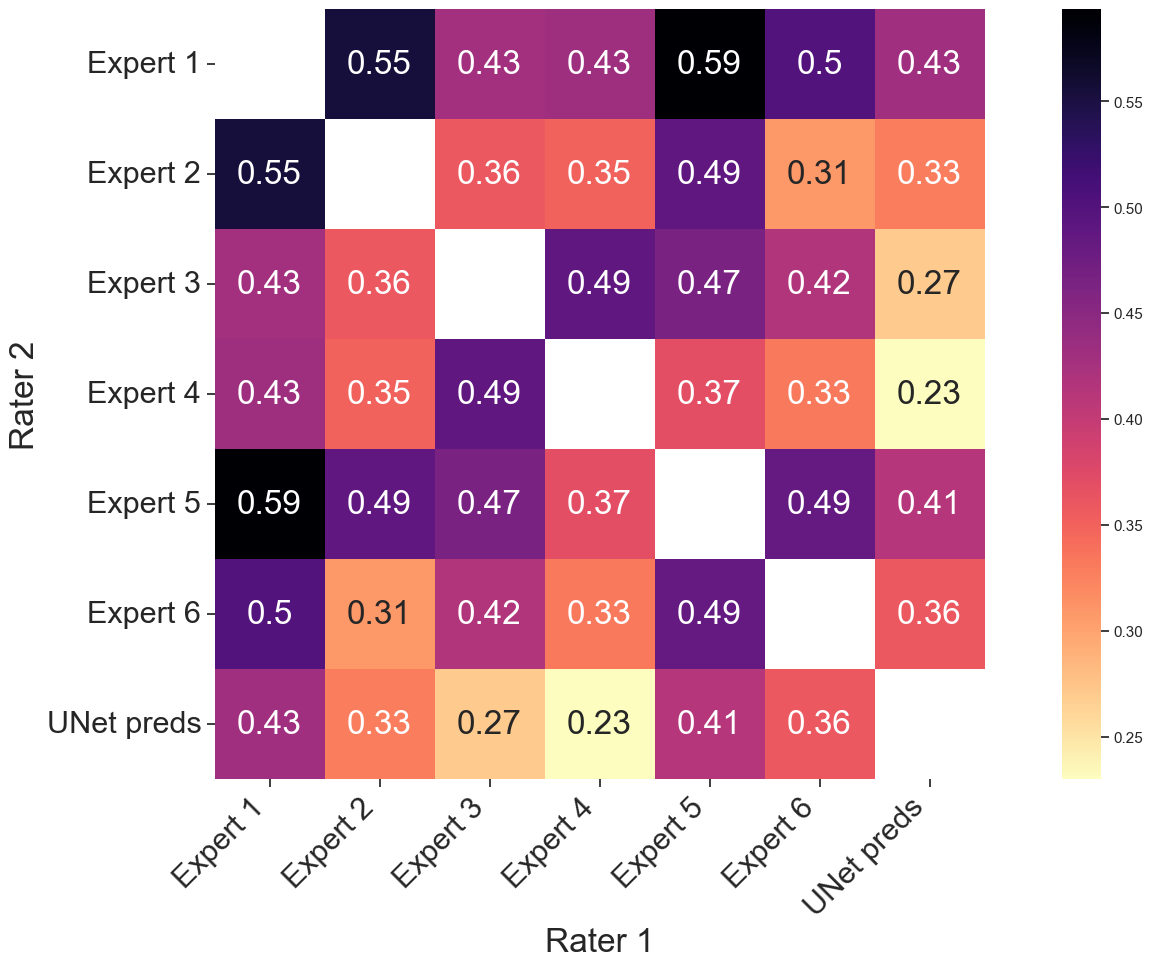

In [45]:
# same as before but without ground truth
sns.set_style("ticks")

avg_kappa_df_no_gt = kappa_df_no_gt.pivot_table(
    index="annotator_1", columns="annotator_2", values="kappa", aggfunc="mean"
)


plt.figure(figsize=(20, 10))

ax = sns.heatmap(
    avg_kappa_df_no_gt,
    annot=True,
    cmap=sns.color_palette("magma_r", as_cmap=True),
    annot_kws={"size": 24},
    square=True,
)
ax.set_xlabel("Rater 1", fontsize=24)
ax.set_ylabel("Rater 2", fontsize=24)

tick_labels = [
    "Expert 1",
    "Expert 2",
    "Expert 3",
    "Expert 4",
    "Expert 5",
    "Expert 6",
    "UNet preds",
]
ax.set_xticklabels(tick_labels, rotation=45, ha="right", fontsize=22)
ax.set_yticklabels(tick_labels, rotation=0, ha="right", fontsize=22)

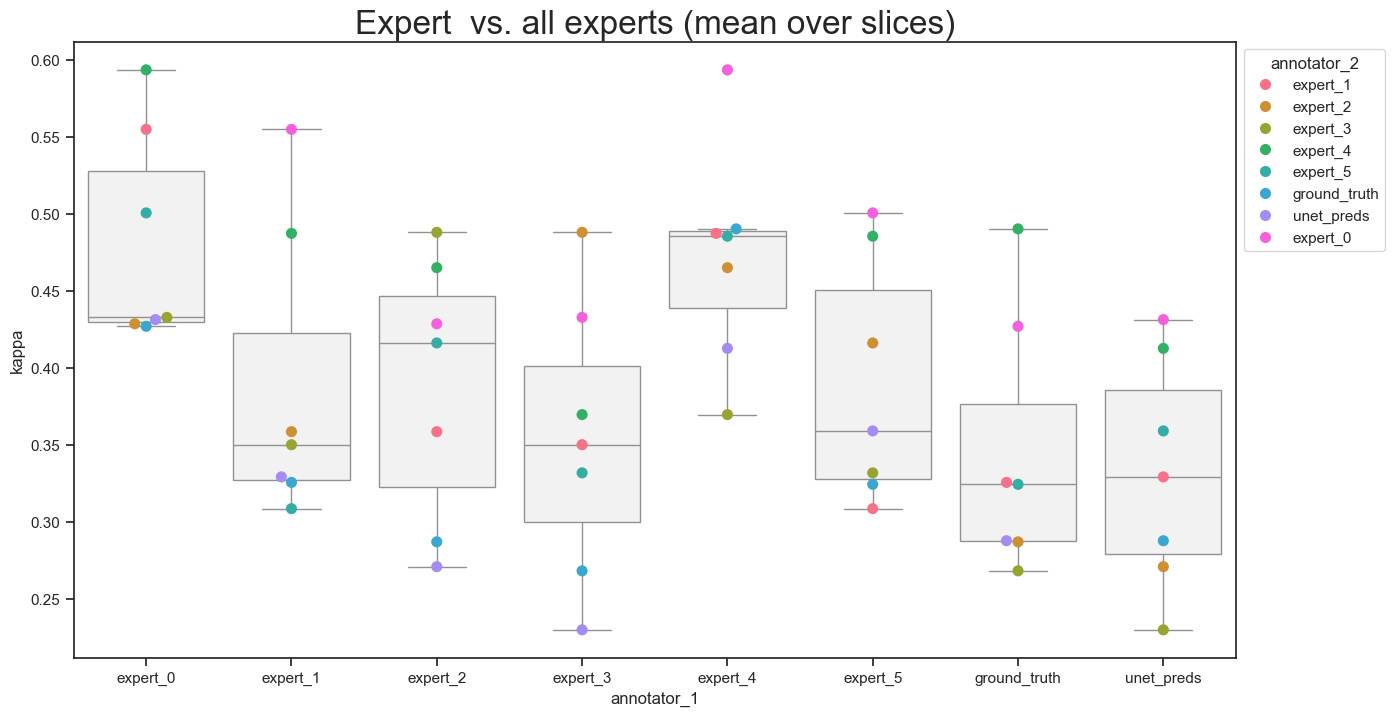

In [46]:
# compute average kappa values over all slices in a new dataframe without slice column
slices_avg_df = (
    kappa_df.groupby(["annotator_1", "annotator_2"])
    .mean(numeric_only=True)
    .reset_index()
)

plt.figure(figsize=(15, 8))
# sns.set_theme(style="whitegrid")
sns.set_style("ticks")

ax = sns.boxplot(x="annotator_1", y="kappa", data=slices_avg_df, color=".95")
ax = sns.swarmplot(
    x="annotator_1",
    y="kappa",
    data=slices_avg_df,
    hue="annotator_2",
    palette="husl",
    size=8,
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.title("Expert  vs. all experts (mean over slices)", fontsize=24)

plt.show()

## Majority vote

TODO: decide whether include ground truth in majority vote of experts or not...

In [47]:
# compute majority vote among all annotators except for unet_preds and ground truth
all_majority_votes = {}
for slice_id in slices_ids:
    all_majority_votes[slice_id] = {}
    for expert in all_segmentations.keys():
        # compute majority vote for all experts and for all experts except for one

        if expert == "unet_preds":
            # compute majority vote for all experts
            count_votes = []
            for other_expert in all_segmentations.keys():
                if other_expert not in ["ground_truth", "unet_preds"]:
                    count_votes.append(
                        all_segmentations[other_expert][slice_id])
            all_majority_votes[slice_id][expert] = scipy.stats.mode(
                count_votes, axis=0, keepdims=False
            )[0]

        elif expert not in ["ground_truth", "unet_preds"]:
            # compute majority vote for all experts except for one
            count_votes = []
            for other_expert in all_segmentations.keys():
                if other_expert not in ["ground_truth", "unet_preds", expert]:
                    count_votes.append(
                        all_segmentations[other_expert][slice_id])
            all_majority_votes[slice_id][expert] = scipy.stats.mode(
                count_votes, axis=0, keepdims=False
            )[0]

# same but including unet_preds in majority vote
all_majority_votes_unet = {}
for slice_id in slices_ids:
    all_majority_votes_unet[slice_id] = {}
    for expert in all_segmentations.keys():
        if expert not in ["ground_truth"]:
            # compute majority vote for all experts except for one
            count_votes = []
            for other_expert in all_segmentations.keys():
                if other_expert not in ["ground_truth", expert]:
                    count_votes.append(
                        all_segmentations[other_expert][slice_id])

            all_majority_votes_unet[slice_id][expert] = scipy.stats.mode(
                count_votes, axis=0, keepdims=False
            )[0]

In [48]:
# for each slice, for each expert and UNet, compute kappa wrt majority vote

majority_list = []
for slice_id in slices_ids:
    for expert in all_segmentations.keys():
        if expert != "ground_truth":
            majority_list.append(
                {
                    "slice_id": slice_id,
                    "Rater": expert,
                    # 'Majority': 'majority_vote_wrt_'+expert,
                    "Kappa": cohen_kappa_score(
                        all_majority_votes[slice_id][expert].flatten(),
                        all_segmentations[expert][slice_id].flatten(),
                        labels=[0, 1, 2, 3],
                    ),
                }
            )

# same but including unet_preds in majority vote
majority_list_unet = []
for slice_id in slices_ids:
    for expert in all_segmentations.keys():
        if expert != "ground_truth":
            majority_list_unet.append(
                {
                    "slice_id": slice_id,
                    "Rater": expert,
                    # 'Majority': 'majority_vote_wrt_'+expert,
                    "Kappa": cohen_kappa_score(
                        all_majority_votes_unet[slice_id][expert].flatten(),
                        all_segmentations[expert][slice_id].flatten(),
                        labels=[0, 1, 2, 3],
                    ),
                }
            )

In [49]:
majority_df = pd.DataFrame(majority_list)
majority_df_unet = pd.DataFrame(majority_list_unet)

C:\Users\dotti\AppData\Local\Temp\ipykernel_10364\1397128519.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_labels)  # , ha='right')


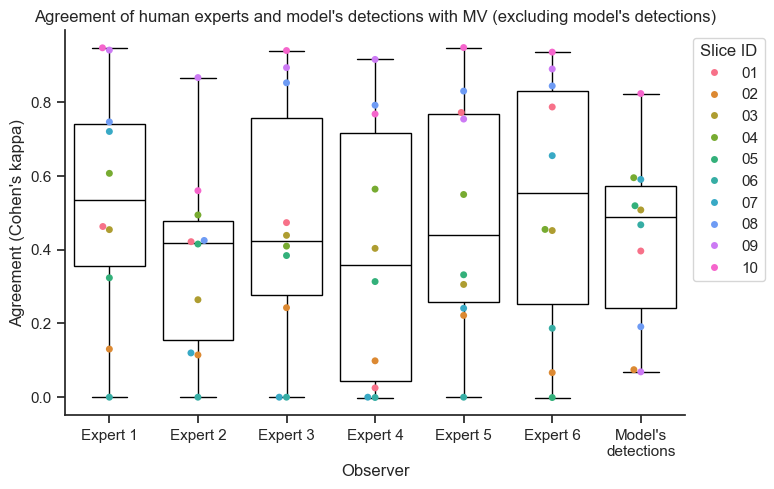

C:\Users\dotti\AppData\Local\Temp\ipykernel_10364\1397128519.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_labels)  # , ha='right')


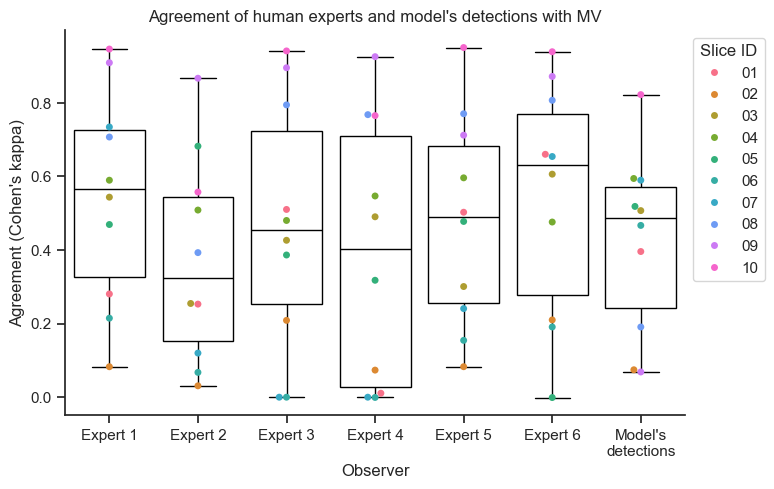

In [50]:
# set font size to 24
matplotlib.rcParams.update({"font.size": 22})

# set directory where plots will be saved
out_dir = r"C:\Users\dotti\OneDrive - Universitaet Bern\manuscript figures"

# create palette where unet_preds is dark grey and all other experts are light grey
sns.set_color_codes()
pal = {
    rater: "darkgray" if rater == "unet_preds" else "lightgray"
    for rater in majority_df.Rater.unique()
}

# plot kappa values for each annotator wrt majority vote
plt.figure(figsize=(8, 5))
sns.set_style("ticks")

ax = sns.boxplot(
    x="Rater", y="Kappa", data=majority_df, linewidth=1, **PROPS
)  # , palette=pal)
ax = sns.swarmplot(
    x="Rater", y="Kappa", data=majority_df, hue="slice_id", palette="husl"
)  # , size=8)

tick_labels = [
    "Expert 1",
    "Expert 2",
    "Expert 3",
    "Expert 4",
    "Expert 5",
    "Expert 6",
    "Model's\ndetections",
]
ax.set_xticklabels(tick_labels)  # , ha='right')
ax.set(xlabel="Observer", ylabel="Agreement (Cohen's kappa)")

plt.legend(title="Slice ID", loc="upper left", bbox_to_anchor=(1, 1))

plt.title(
    "Agreement of human experts and model's detections with MV (excluding model's detections)"
)

# plt.savefig(os.path.join(out_dir, 'kappa_majority_vote.svg'), transparent=True)
sns.despine()
plt.show()

# plot kappa values for each annotator wrt majority vote including unet_preds
plt.figure(figsize=(8, 5))
sns.set_style("ticks")

ax = sns.boxplot(
    x="Rater", y="Kappa", data=majority_df_unet, linewidth=1, **PROPS
)  # palette=pal)
ax = sns.swarmplot(
    x="Rater", y="Kappa", data=majority_df_unet, hue="slice_id", palette="husl"
)  # , size=8)

tick_labels = [
    "Expert 1",
    "Expert 2",
    "Expert 3",
    "Expert 4",
    "Expert 5",
    "Expert 6",
    "Model's\ndetections",
]
ax.set_xticklabels(tick_labels)  # , ha='right')
ax.set(xlabel="Observer", ylabel="Agreement (Cohen's kappa)")

plt.legend(title="Slice ID", loc="upper left", bbox_to_anchor=(1, 1))

plt.title("Agreement of human experts and model's detections with MV")

# plt.savefig(os.path.join(out_dir, 'kappa_majority_vote_unet.svg'), transparent=True)
sns.despine()
plt.show()

In [51]:
# don't use mean and std but median and var because
# I am assuming that the distribution is not normal!

In [52]:
majority_df.groupby("Rater").agg({"Kappa": ["median", "var"]}).to_csv(
    os.path.join(out_dir, "kappa_majority_vote.csv")
)
majority_df_unet.groupby("Rater").agg({"Kappa": ["median", "var"]}).to_csv(
    os.path.join(out_dir, "kappa_majority_vote_unet.csv")
)

In [53]:
majority_df.groupby("Rater").agg({"Kappa": ["median", "var"]})

Kappa          
              median       var
Rater                         
expert_0    0.534356  0.102638
expert_1    0.418074  0.064504
expert_2    0.423834  0.116614
expert_3    0.358168  0.126407
expert_4    0.440314  0.101014
expert_5    0.554370  0.122026
unet_preds  0.487092  0.059632

In [54]:
majority_df_unet.groupby("Rater").agg({"Kappa": ["median", "var"]})

Kappa          
              median       var
Rater                         
expert_0    0.566813  0.084024
expert_1    0.323892  0.077279
expert_2    0.453465  0.114314
expert_3    0.404141  0.128825
expert_4    0.490261  0.080744
expert_5    0.630290  0.100014
unet_preds  0.487092  0.059632

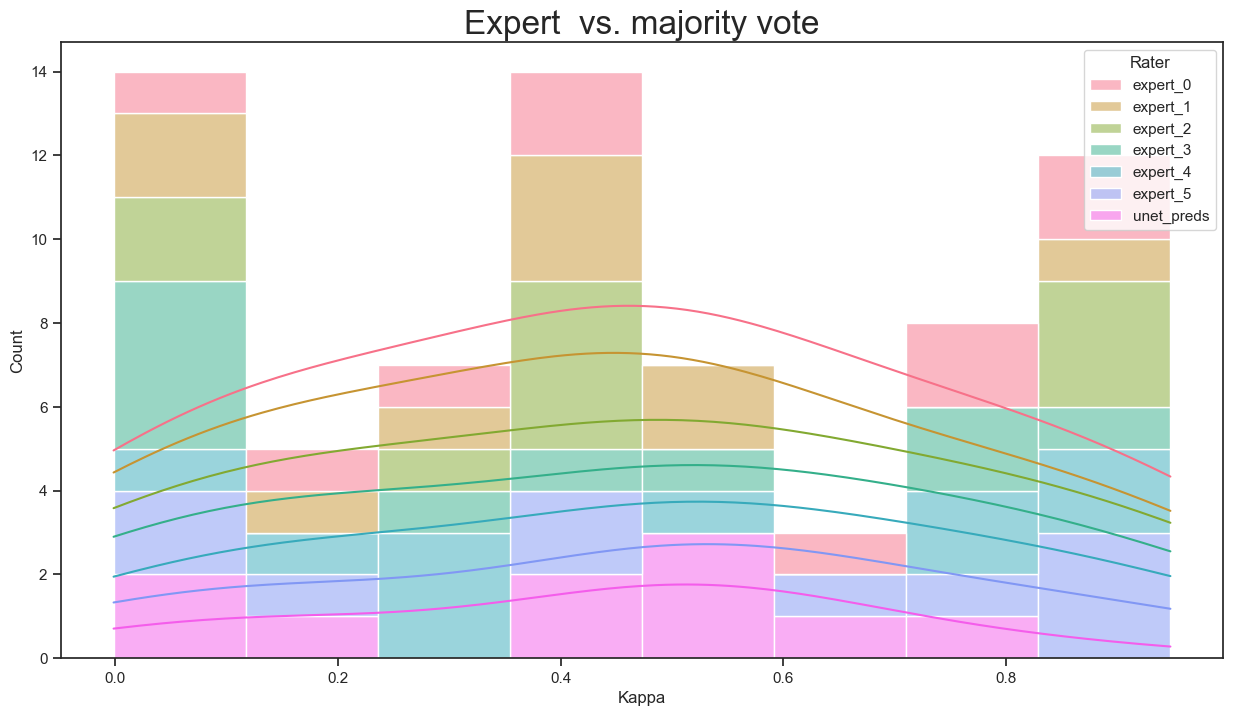

In [55]:
# plot histogram of kappa values for each annotator wrt majority vote
plt.figure(figsize=(15, 8))
# sns.set_theme(style="whitegrid")
sns.set_style("ticks")

ax = sns.histplot(
    data=majority_df, x="Kappa", hue="Rater", multiple="stack", palette="husl", kde=True
)

plt.title("Expert  vs. majority vote", fontsize=24)

plt.show()

### Compute kruskal-wallis test

In [56]:
# get dataframe of kappa values for each annotator wrt majority vote
majority_df_pivot = majority_df.pivot(
    index="Rater", columns="slice_id", values="Kappa")
majority_df_unet_pivot = majority_df_unet.pivot(
    index="Rater", columns="slice_id", values="Kappa"
)

In [57]:
# compute kruskal-wallis test for all annotators
stat, p = kruskal(*majority_df_pivot.values.tolist())
print("Statistics=%.3f, p=%.3f" % (stat, p))

Statistics=2.549, p=0.863


In [58]:
# compute kruskal-wallis test for all annotators when unet is included in majority vote
stat_unet, p_unet = kruskal(*majority_df_unet_pivot.values.tolist())
print("Statistics=%.3f, p=%.3f" % (stat_unet, p_unet))

Statistics=3.264, p=0.775


In [59]:
p_adjustment = "holm"  # "holm"  # bonferroni

pvalues = sp.posthoc_dunn(
    majority_df_pivot.values.tolist(), p_adjust=p_adjustment)
pvalues_unet = sp.posthoc_dunn(
    majority_df_unet_pivot.values.tolist(), p_adjust=p_adjustment
)

print("p values for each annotator wrt majority vote")
print(pvalues)

print("p values for each annotator wrt majority vote (including unet_preds)")
print(pvalues_unet)

p values for each annotator wrt majority vote
     1    2    3    4    5    6    7
1  1.0  1.0  1.0  1.0  1.0  1.0  1.0
2  1.0  1.0  1.0  1.0  1.0  1.0  1.0
3  1.0  1.0  1.0  1.0  1.0  1.0  1.0
4  1.0  1.0  1.0  1.0  1.0  1.0  1.0
5  1.0  1.0  1.0  1.0  1.0  1.0  1.0
6  1.0  1.0  1.0  1.0  1.0  1.0  1.0
7  1.0  1.0  1.0  1.0  1.0  1.0  1.0
p values for each annotator wrt majority vote (including unet_preds)
     1    2    3    4    5    6    7
1  1.0  1.0  1.0  1.0  1.0  1.0  1.0
2  1.0  1.0  1.0  1.0  1.0  1.0  1.0
3  1.0  1.0  1.0  1.0  1.0  1.0  1.0
4  1.0  1.0  1.0  1.0  1.0  1.0  1.0
5  1.0  1.0  1.0  1.0  1.0  1.0  1.0
6  1.0  1.0  1.0  1.0  1.0  1.0  1.0
7  1.0  1.0  1.0  1.0  1.0  1.0  1.0


### Check if UNet is non-inferior to experts' mean

In [60]:
# compute average kappa score for each annotator (without unet_preds) wrt majority vote
majority_df_pivot_t = majority_df.pivot(
    index="slice_id", columns="Rater", values="Kappa"
)
# compute mean for all experts and add it to majority dataframe
majority_df_pivot_t["expert_mean"] = majority_df_pivot_t[
    ["expert_0", "expert_1", "expert_2", "expert_3", "expert_4", "expert_5"]
].mean(axis=1)

display(majority_df_pivot_t)


means_per_slice = dict(
    majority_df_pivot_t[
        ["expert_0", "expert_1", "expert_2", "expert_3", "expert_4", "expert_5"]
    ].mean(axis=1)
)

cols = majority_df.columns.tolist()
majority_df_with_mean = majority_df.copy()
for slice_id, mean in means_per_slice.items():
    mean_df = pd.DataFrame([[slice_id, "expert_mean", mean]], columns=cols)
    majority_df_with_mean = pd.concat(
        [majority_df_with_mean, mean_df], ignore_index=True
    )

# compute average kappa score for each annotator (including unet_preds) wrt majority vote
majority_df_unet_pivot_t = majority_df_unet.pivot(
    index="slice_id", columns="Rater", values="Kappa"
)
# compute mean for all experts
majority_df_unet_pivot_t["expert_mean_unet"] = majority_df_unet_pivot_t[
    ["expert_0", "expert_1", "expert_2", "expert_3", "expert_4", "expert_5"]
].mean(axis=1)

display(majority_df_unet_pivot_t)

means_per_slice_unet = dict(
    majority_df_unet_pivot_t[
        ["expert_0", "expert_1", "expert_2", "expert_3", "expert_4", "expert_5"]
    ].mean(axis=1)
)

cols = majority_df_unet.columns.tolist()
majority_df_unet_with_mean = majority_df_unet.copy()
for slice_id, mean in means_per_slice_unet.items():
    mean_df = pd.DataFrame(
        [[slice_id, "expert_mean_unet", mean]], columns=cols)
    majority_df_unet_with_mean = pd.concat(
        [majority_df_unet_with_mean, mean_df], ignore_index=True
    )

Rater     expert_0  expert_1  expert_2  expert_3  expert_4  expert_5  \
slice_id                                                               
01        0.462349  0.421245  0.472897  0.025125  0.771156  0.786107   
02        0.130340  0.114431  0.242428  0.098536  0.221466  0.066489   
03        0.453925  0.264042  0.438408  0.403134  0.305403  0.451409   
04        0.606363  0.493602  0.409260  0.563618  0.549052  0.454473   
05        0.323373  0.414902  0.383684  0.313201  0.331575 -0.000978   
06        0.000000  0.000000  0.000000 -0.000847  0.000000  0.186662   
07        0.719788  0.119897  0.000000  0.000000  0.240877  0.654267   
08        0.745637  0.424568  0.851576  0.790935  0.829211  0.843102   
09        0.940343  0.865788  0.892732  0.914970  0.753366  0.889046   
10        0.946416  0.559435  0.939020  0.767113  0.947121  0.934762   

Rater     unet_preds  expert_mean  
slice_id                           
01          0.395991     0.489813  
02          0.074525     0.145615  
03          0.507221     0.386054  
04          0.594535     0.512728  
05          0.518594     0.294293  
06          0.466962     0.030969  
07          0.589846     0.289138  
08          0.190876     0.747505  
09          0.068594     0.876041  
10          0.822516     0.848978

Rater     expert_0  expert_1  expert_2  expert_3  expert_4  expert_5  \
slice_id                                                               
01        0.280639  0.253032  0.510358  0.010775  0.502777  0.660291   
02        0.082804  0.030913  0.208814  0.073614  0.082881  0.210049   
03        0.543788  0.254767  0.426531  0.490433  0.300829  0.606314   
04        0.589838  0.508701  0.480400  0.546969  0.596298  0.476169   
05        0.469402  0.682347  0.386556  0.317850  0.477746 -0.000972   
06        0.214799  0.067452  0.000000 -0.000708  0.154500  0.190922   
07        0.734496  0.119897  0.000000  0.000000  0.240877  0.654267   
08        0.707244  0.393017  0.794605  0.768087  0.770550  0.807093   
09        0.909240  0.867065  0.895507  0.925654  0.712288  0.871913   
10        0.946399  0.557632  0.941279  0.765433  0.950470  0.939089   

Rater     unet_preds  expert_mean_unet  
slice_id                                
01          0.395991          0.369645  
02          0.074525          0.114846  
03          0.507221          0.437110  
04          0.594535          0.533062  
05          0.518594          0.388822  
06          0.466962          0.104494  
07          0.589846          0.291590  
08          0.190876          0.706766  
09          0.068594          0.863611  
10          0.822516          0.850050

C:\Users\dotti\AppData\Local\Temp\ipykernel_10364\1505423356.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_labels)


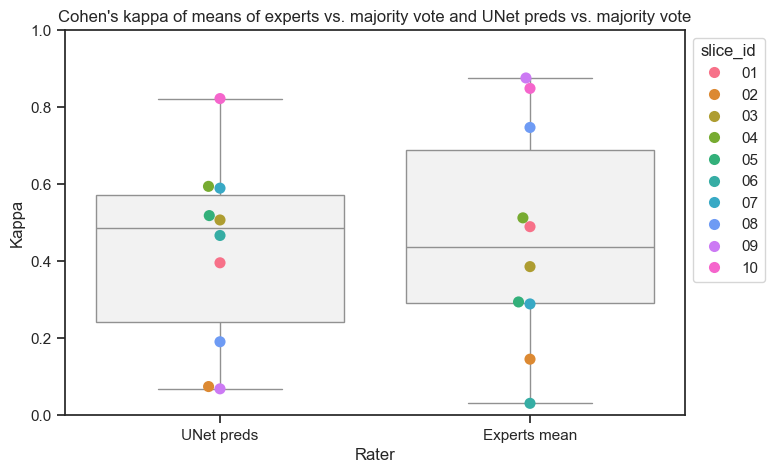

C:\Users\dotti\AppData\Local\Temp\ipykernel_10364\1505423356.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_labels)


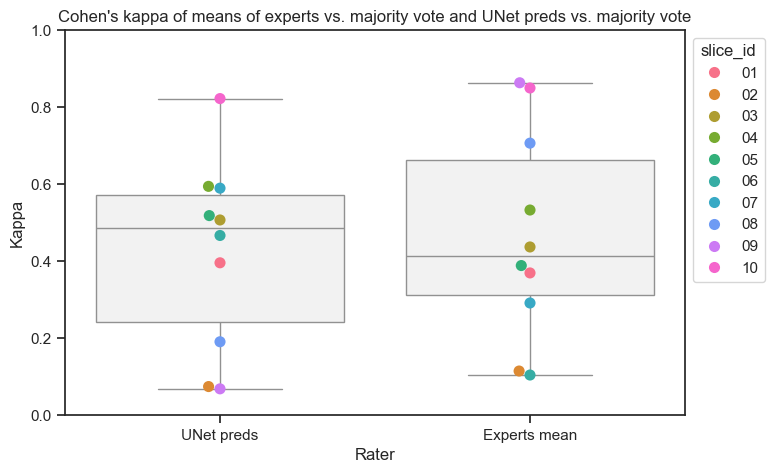

In [62]:
# plot average kappa score for each annotator (without unet_preds) wrt majority vote
plt.figure(figsize=(8, 5))
# sns.set_theme(style="whitegrid")
sns.set_style("ticks")

df_subset = majority_df_with_mean[
    majority_df_with_mean["Rater"].isin(["expert_mean", "unet_preds"])
]
ax = sns.boxplot(
    x="Rater",
    y="Kappa",
    data=df_subset,
    order=["unet_preds", "expert_mean"],
    color=".95",
)
ax = sns.swarmplot(
    x="Rater",
    y="Kappa",
    data=df_subset,
    order=["unet_preds", "expert_mean"],
    hue="slice_id",
    palette="husl",
    size=8,
)  # , color=".25", size=3)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

tick_labels = ["UNet preds", "Experts mean"]
ax.set_xticklabels(tick_labels)

# set y axis limits
ax.set_ylim(0, 1)

plt.title(
    "Cohen's kappa of means of experts vs. majority vote and UNet preds vs. majority vote",
    fontsize=12,
)

plt.show()

# plot average kappa score for each annotator (including unet_preds) wrt majority vote
plt.figure(figsize=(8, 5))
# sns.set_theme(style="whitegrid")
sns.set_style("ticks")

df_subset = majority_df_unet_with_mean[
    majority_df_unet_with_mean["Rater"].isin(
        ["expert_mean_unet", "unet_preds"])
]
ax = sns.boxplot(
    x="Rater",
    y="Kappa",
    data=df_subset,
    order=["unet_preds", "expert_mean_unet"],
    color=".95",
)
ax = sns.swarmplot(
    x="Rater",
    y="Kappa",
    data=df_subset,
    order=["unet_preds", "expert_mean_unet"],
    hue="slice_id",
    palette="husl",
    size=8,
)  # , color=".25", size=3)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

tick_labels = ["UNet preds", "Experts mean"]
ax.set_xticklabels(tick_labels)

# set y axis limits
ax.set_ylim(0, 1)

plt.title(
    "Cohen's kappa of means of experts vs. majority vote and UNet preds vs. majority vote",
    fontsize=12,
)

plt.show()

In [63]:
# concatenate dataframes containing unet_preds, expert_mean and expert_mean_unet
only_mean_df = pd.concat(
    [
        majority_df_with_mean[
            majority_df_with_mean["Rater"].isin(["expert_mean", "unet_preds"])
        ],
        majority_df_unet_with_mean[
            majority_df_unet_with_mean["Rater"].isin(["expert_mean_unet"])
        ],
    ],
    ignore_index=True,
)

C:\Users\dotti\AppData\Local\Temp\ipykernel_10364\2195996282.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_labels)


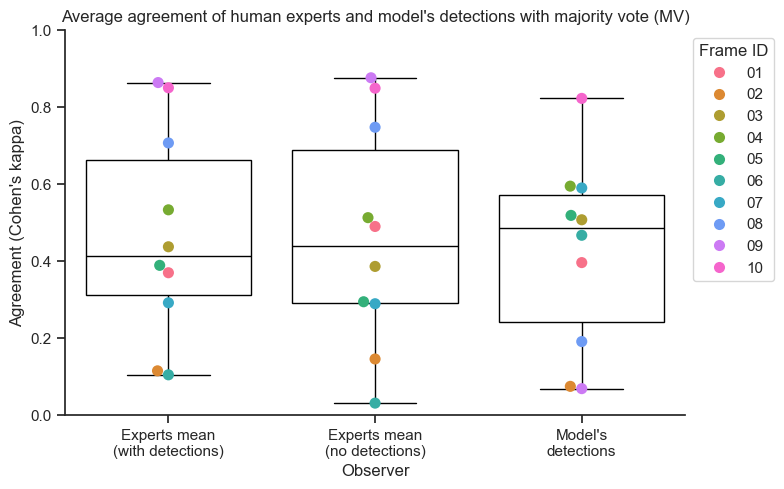

In [64]:
# set font size to 24
matplotlib.rcParams.update({"font.size": 22})

# set directory where plots will be saved
out_dir = r"C:\Users\dotti\OneDrive - Universitaet Bern\manuscript figures"

# create palette where unet_preds is dark grey and all other experts are light grey
sns.set_color_codes()
pal = {
    rater: "darkgray" if rater == "unet_preds" else "lightgray"
    for rater in only_mean_df.Rater.unique()
}

# plot average kappa score for each annotator (without and with unet_preds) wrt majority vote
plt.figure(figsize=(8, 5))
sns.set_theme(style="ticks")

ax = sns.boxplot(
    x="Rater",
    y="Kappa",
    data=only_mean_df,
    order=["expert_mean_unet", "expert_mean", "unet_preds"],
    linewidth=1,
    **PROPS
    # palette=pal
)
ax = sns.swarmplot(
    x="Rater",
    y="Kappa",
    data=only_mean_df,
    order=["expert_mean_unet", "expert_mean", "unet_preds"],
    hue="slice_id",
    palette="husl",
    size=8,
)  # , color=".25", size=3)

plt.legend(title="Frame ID", loc="upper left", bbox_to_anchor=(1, 1))

tick_labels = [
    "Experts mean\n(with detections)",
    "Experts mean\n(no detections)",
    "Model's\ndetections",
]
ax.set_xticklabels(tick_labels)

# set y axis limits
ax.set_ylim(0, 1)
ax.set(xlabel="Observer", ylabel="Agreement (Cohen's kappa)")

plt.title(
    "Average agreement of human experts and model's detections with majority vote (MV)"
)

plt.savefig(os.path.join(out_dir, "mean_kappa_majority_vote.svg"),
            transparent=True)

sns.despine()
plt.show()

In [65]:
# compute if unet_preds is non-inferior to expert_mean
tstat, pvalue = one_sided_non_inferiority_ttest(
    sample1=majority_df_pivot_t["expert_mean"],
    sample2=majority_df_pivot_t["unet_preds"],
    increase_is_desirable=True,
)

print("tstat (without unet preds): ", tstat)
print("pvalue (without unet preds): ", pvalue)

tstat_unet, pvalue_unet = one_sided_non_inferiority_ttest(
    sample1=majority_df_unet_pivot_t["expert_mean_unet"],
    sample2=majority_df_unet_pivot_t["unet_preds"],
    increase_is_desirable=True,
)

print("tstat (with unet preds): ", tstat_unet)
print("pvalue (with unet preds): ", pvalue_unet)

tstat (without unet preds):  0.32407963214535407
pvalue (without unet preds):  0.3766412579406661
tstat (with unet preds):  0.3842846233670569
pvalue (with unet preds):  0.354844817633522


### Compute inter-rater agreement of experts only using Fleiss' kappa

In [66]:
experts_ids = [key for key in all_segmentations.keys() if "expert" in key]

# for each slice, gather all flattened annotators' segmentations as data array
flattened_segmentations = {}
for slice_id in slices_ids:
    for expert in experts_ids:
        if slice_id not in flattened_segmentations.keys():
            flattened_segmentations[slice_id] = []
        flattened_segmentations[slice_id].append(
            all_segmentations[expert][slice_id].flatten()
        )

    # transform list in array and transpose
    flattened_segmentations[slice_id] = np.array(
        flattened_segmentations[slice_id]).T

In [67]:
# aggregate raters
aggregated_segmentations = {}
for slice_id in slices_ids:
    aggregated_segmentations[slice_id] = aggregate_raters(
        flattened_segmentations[slice_id], n_cat=4
    )[0]

In [68]:
# compute fleiss kappa
fleiss_scores = {}
for slice_id in slices_ids:
    fleiss_scores[slice_id] = fleiss_kappa(
        table=aggregated_segmentations[slice_id])

In [69]:
# store fleiss kappa scores in dataframe
fleiss_df = pd.DataFrame.from_dict(
    fleiss_scores, orient="index", columns=["Fleiss_Kappa"]
)

In [70]:
fleiss_df

Fleiss_Kappa
01      0.400073
02      0.262500
03      0.392914
04      0.498582
05      0.411116
06      0.210344
07      0.140142
08      0.635179
09      0.817437
10      0.775755

In [77]:
# Compute Fleiss kappa for binary segmentations

# for each slice, gather all flattened annotators' segmentations as data array
flattened_binary_segmentations = {}
for slice_id in slices_ids:
    for expert in experts_ids:
        if slice_id not in flattened_binary_segmentations.keys():
            flattened_binary_segmentations[slice_id] = []
        flattened_binary_segmentations[slice_id].append(
            (all_segmentations[expert][slice_id] != 0).flatten()
        )

    # transform list in array and transpose
    flattened_binary_segmentations[slice_id] = np.array(
        flattened_binary_segmentations[slice_id], dtype=int
    ).T

In [78]:
# aggregate raters
aggregated_binary_segmentations = {}
for slice_id in slices_ids:
    aggregated_binary_segmentations[slice_id] = aggregate_raters(
        flattened_binary_segmentations[slice_id], n_cat=4
    )[0]

In [79]:
# compute fleiss kappa
binary_fleiss_scores = {}
for slice_id in slices_ids:
    binary_fleiss_scores[slice_id] = fleiss_kappa(
        table=aggregated_binary_segmentations[slice_id]
    )

In [80]:
# store fleiss kappa scores in dataframe
binary_fleiss_df = pd.DataFrame.from_dict(
    binary_fleiss_scores, orient="index", columns=["Fleiss_Kappa"]
)

In [84]:
display(fleiss_df), display(binary_fleiss_df)

Fleiss_Kappa
01      0.400073
02      0.262500
03      0.392914
04      0.498582
05      0.411116
06      0.210344
07      0.140142
08      0.635179
09      0.817437
10      0.775755

Fleiss_Kappa
01      0.423724
02      0.379940
03      0.535884
04      0.626976
05      0.587802
06      0.275065
07      0.140142
08      0.764101
09      0.820575
10      0.775755

(None, None)

## Compute same analysis with ground truth instead of unet preds

In [139]:
# compute majority vote among all annotators except for ground truth
all_majority_votes_gt = {}
for slice_id in slices_ids:
    all_majority_votes_gt[slice_id] = {}
    for expert in all_segmentations.keys():
        # compute majority vote for all experts and for all experts except for one

        if expert == "ground_truth":
            # compute majority vote for all experts
            count_votes = []
            for other_expert in all_segmentations.keys():
                if other_expert not in ["ground_truth", "unet_preds"]:
                    count_votes.append(
                        all_segmentations[other_expert][slice_id])
            all_majority_votes_gt[slice_id][expert] = scipy.stats.mode(
                count_votes, axis=0, keepdims=False
            )[0]

        elif expert not in ["ground_truth", "unet_preds"]:
            # compute majority vote for all experts except for one
            count_votes = []
            for other_expert in all_segmentations.keys():
                if other_expert not in ["ground_truth", "unet_preds", expert]:
                    count_votes.append(
                        all_segmentations[other_expert][slice_id])
            all_majority_votes_gt[slice_id][expert] = scipy.stats.mode(
                count_votes, axis=0, keepdims=False
            )[0]

# same but including unet_preds in majority vote
all_majority_votes_gt_with_gt = {}
for slice_id in slices_ids:
    all_majority_votes_gt_with_gt[slice_id] = {}
    for expert in all_segmentations.keys():
        if expert not in ["unet_preds"]:
            # compute majority vote for all experts except for one
            count_votes = []
            for other_expert in all_segmentations.keys():
                if other_expert not in ["unet_preds", expert]:
                    count_votes.append(
                        all_segmentations[other_expert][slice_id])

            all_majority_votes_gt_with_gt[slice_id][expert] = scipy.stats.mode(
                count_votes, axis=0, keepdims=False
            )[0]

In [140]:
# for each slice, for each expert and GT, compute kappa wrt majority vote

majority_gt_list = []
for slice_id in slices_ids:
    for expert in all_segmentations.keys():
        if expert != "unet_preds":
            majority_gt_list.append(
                {
                    "slice_id": slice_id,
                    "Rater": expert,
                    "Kappa": cohen_kappa_score(
                        all_majority_votes_gt[slice_id][expert].flatten(),
                        all_segmentations[expert][slice_id].flatten(),
                        labels=[0, 1, 2, 3],
                    ),
                }
            )

# same but including GT in majority vote
majority_list_gt_with_gt = []
for slice_id in slices_ids:
    for expert in all_segmentations.keys():
        if expert != "unet_preds":
            majority_list_gt_with_gt.append(
                {
                    "slice_id": slice_id,
                    "Rater": expert,
                    "Kappa": cohen_kappa_score(
                        all_majority_votes_gt_with_gt[slice_id][expert].flatten(
                        ),
                        all_segmentations[expert][slice_id].flatten(),
                        labels=[0, 1, 2, 3],
                    ),
                }
            )

In [141]:
majority_gt_df = pd.DataFrame(majority_gt_list)
majority_gt_df_with_gt = pd.DataFrame(majority_list_gt_with_gt)

In [142]:
# set font size to 24
matplotlib.rcParams.update({"font.size": 22})

# set directory where plots will be saved
out_dir = r"C:\Users\dotti\OneDrive - Universitaet Bern\manuscript figures\annotated dataset validation"

# create palette where unet_preds is dark grey and all other experts are light grey
sns.set_color_codes()
pal = {
    rater: "darkgray" if rater == "ground_truth" else "lightgray"
    for rater in majority_gt_df.Rater.unique()
}

# plot kappa values for each annotator wrt majority vote
plt.figure(figsize=(8, 5))
sns.set_theme(style="ticks")

ax = sns.boxplot(
    x="Rater",
    y="Kappa",
    data=majority_gt_df,
    linewidth=1,
    **PROPS
    # palette=pal
)
ax = sns.swarmplot(
    x="Rater", y="Kappa", data=majority_gt_df, hue="slice_id", palette="husl"
)  # , size=8)

tick_labels = [
    "Expert 1",
    "Expert 2",
    "Expert 3",
    "Expert 4",
    "Expert 5",
    "Expert 6",
    "Labels",
]
ax.set_ylim(0, 1)
ax.set_xticklabels(tick_labels)  # , ha='right')
ax.set(xlabel="Observer", ylabel="Agreement (Cohen's kappa)")

plt.legend(title="Frame ID", loc="upper left", bbox_to_anchor=(1, 1))

plt.title("Agreement of human experts and our labels with MV (excluding our labels)")

plt.savefig(os.path.join(out_dir, "kappa_majority_vote_GT.svg"),
            transparent=True)

sns.despine()
plt.show()

# plot kappa values for each annotator wrt majority vote including unet_preds
plt.figure(figsize=(8, 5))
sns.set_theme(style="ticks")

ax = sns.boxplot(
    x="Rater",
    y="Kappa",
    data=majority_gt_df_with_gt,
    linewidth=1,
    **PROPS
    # palette=pal
)
ax = sns.swarmplot(
    x="Rater", y="Kappa", data=majority_gt_df_with_gt, hue="slice_id", palette="husl"
)  # , size=8)

tick_labels = [
    "Expert 1",
    "Expert 2",
    "Expert 3",
    "Expert 4",
    "Expert 5",
    "Expert 6",
    "Labels",
]
ax.set_ylim(0, 1)
ax.set_xticklabels(tick_labels)  # , ha='right')
ax.set(xlabel="Observer", ylabel="Agreement (Cohen's kappa)")

plt.legend(title="Frame ID", loc="upper left", bbox_to_anchor=(1, 1))

plt.title("Agreement of human experts and our labels with MV")

plt.savefig(
    os.path.join(out_dir, "kappa_majority_vote_GT_with_GT.svg"), transparent=True
)

sns.despine()
plt.show()

In [143]:
# majority_gt_df.groupby('Rater').agg({'Kappa': ['median', 'var']}).to_csv(os.path.join(out_dir, 'kappa_majority_vote.csv'))
# majority_gt_df_with_gt.groupby('Rater').agg({'Kappa': ['median', 'var']}).to_csv(os.path.join(out_dir, 'kappa_majority_vote_unet.csv'))

In [144]:
majority_gt_df.groupby("Rater").agg({"Kappa": ["median", "var"]})

Kappa          
                median       var
Rater                           
expert_0      0.534356  0.102638
expert_1      0.418074  0.064504
expert_2      0.423834  0.116614
expert_3      0.358168  0.126407
expert_4      0.440314  0.101014
expert_5      0.554370  0.122026
ground_truth  0.339006  0.040025

In [145]:
majority_gt_df_with_gt.groupby("Rater").agg({"Kappa": ["median", "var"]})

Kappa          
                median       var
Rater                           
expert_0      0.573999  0.057232
expert_1      0.396440  0.066632
expert_2      0.420283  0.111815
expert_3      0.390454  0.121766
expert_4      0.577781  0.070048
expert_5      0.592332  0.118473
ground_truth  0.339006  0.040025

### Compute kruskal-wallis test

In [147]:
# get dataframe of kappa values for each annotator wrt majority vote
majority_gt_df_pivot = majority_gt_df.pivot(
    index="Rater", columns="slice_id", values="Kappa"
)
majorit_gt_df_with_gt_pivot = majority_gt_df_with_gt.pivot(
    index="Rater", columns="slice_id", values="Kappa"
)

In [148]:
# compute kruskal-wallis test for all annotators
stat, p = kruskal(*majority_gt_df_pivot.values.tolist())
print("Statistics=%.3f, p=%.3f" % (stat, p))

Statistics=3.217, p=0.781


In [149]:
# compute kruskal-wallis test for all annotators when unet is included in majority vote
stat_unet, p_unet = kruskal(*majorit_gt_df_with_gt_pivot.values.tolist())
print("Statistics=%.3f, p=%.3f" % (stat_unet, p_unet))

Statistics=6.100, p=0.412


In [150]:
p_adjustment = "holm"  # "holm"  # bonferroni

pvalues = sp.posthoc_dunn(
    majority_gt_df_pivot.values.tolist(), p_adjust=p_adjustment)
pvalues_unet = sp.posthoc_dunn(
    majorit_gt_df_with_gt_pivot.values.tolist(), p_adjust=p_adjustment
)

print("p values for each annotator wrt majority vote")
print(pvalues)

print("p values for each annotator wrt majority vote (including unet_preds)")
print(pvalues_unet)

p values for each annotator wrt majority vote
     1    2    3    4    5    6    7
1  1.0  1.0  1.0  1.0  1.0  1.0  1.0
2  1.0  1.0  1.0  1.0  1.0  1.0  1.0
3  1.0  1.0  1.0  1.0  1.0  1.0  1.0
4  1.0  1.0  1.0  1.0  1.0  1.0  1.0
5  1.0  1.0  1.0  1.0  1.0  1.0  1.0
6  1.0  1.0  1.0  1.0  1.0  1.0  1.0
7  1.0  1.0  1.0  1.0  1.0  1.0  1.0
p values for each annotator wrt majority vote (including unet_preds)
     1    2    3    4    5    6    7
1  1.0  1.0  1.0  1.0  1.0  1.0  1.0
2  1.0  1.0  1.0  1.0  1.0  1.0  1.0
3  1.0  1.0  1.0  1.0  1.0  1.0  1.0
4  1.0  1.0  1.0  1.0  1.0  1.0  1.0
5  1.0  1.0  1.0  1.0  1.0  1.0  1.0
6  1.0  1.0  1.0  1.0  1.0  1.0  1.0
7  1.0  1.0  1.0  1.0  1.0  1.0  1.0


### Check if dataset labelling is non-inferior to experts' mean

In [151]:
# compute average kappa score for each annotator (without GT) wrt majority vote
majority_gt_df_pivot_t = majority_gt_df.pivot(
    index="slice_id", columns="Rater", values="Kappa"
)
# compute mean for all experts and add it to majority dataframe
majority_gt_df_pivot_t["expert_mean"] = majority_gt_df_pivot_t[
    ["expert_0", "expert_1", "expert_2", "expert_3", "expert_4", "expert_5"]
].mean(axis=1)

display(majority_gt_df_pivot_t)


means_per_slice = dict(
    majority_gt_df_pivot_t[
        ["expert_0", "expert_1", "expert_2", "expert_3", "expert_4", "expert_5"]
    ].mean(axis=1)
)

cols = majority_gt_df.columns.tolist()
majority_gt_df_with_mean = majority_gt_df.copy()
for slice_id, mean in means_per_slice.items():
    mean_df = pd.DataFrame([[slice_id, "expert_mean", mean]], columns=cols)
    majority_gt_df_with_mean = pd.concat(
        [majority_gt_df_with_mean, mean_df], ignore_index=True
    )

# compute average kappa score for each annotator (including GT) wrt majority vote
majority_gt_df_with_gt_pivot_t = majority_gt_df_with_gt.pivot(
    index="slice_id", columns="Rater", values="Kappa"
)
# compute mean for all experts
majority_gt_df_with_gt_pivot_t["expert_mean_gt"] = majority_gt_df_with_gt_pivot_t[
    ["expert_0", "expert_1", "expert_2", "expert_3", "expert_4", "expert_5"]
].mean(axis=1)

display(majority_gt_df_with_gt_pivot_t)

means_per_slice_gt = dict(
    majority_gt_df_with_gt_pivot_t[
        ["expert_0", "expert_1", "expert_2", "expert_3", "expert_4", "expert_5"]
    ].mean(axis=1)
)

cols = majority_gt_df_with_gt.columns.tolist()
majority_gt_df_with_gt_with_mean = majority_gt_df_with_gt.copy()
for slice_id, mean in means_per_slice_gt.items():
    mean_df = pd.DataFrame([[slice_id, "expert_mean_gt", mean]], columns=cols)
    majority_gt_df_with_gt_with_mean = pd.concat(
        [majority_gt_df_with_gt_with_mean, mean_df], ignore_index=True
    )

Rater     expert_0  expert_1  expert_2  expert_3  expert_4  expert_5  \
slice_id                                                               
01        0.462349  0.421245  0.472897  0.025125  0.771156  0.786107   
02        0.130340  0.114431  0.242428  0.098536  0.221466  0.066489   
03        0.453925  0.264042  0.438408  0.403134  0.305403  0.451409   
04        0.606363  0.493602  0.409260  0.563618  0.549052  0.454473   
05        0.323373  0.414902  0.383684  0.313201  0.331575 -0.000978   
06        0.000000  0.000000  0.000000 -0.000847  0.000000  0.186662   
07        0.719788  0.119897  0.000000  0.000000  0.240877  0.654267   
08        0.745637  0.424568  0.851576  0.790935  0.829211  0.843102   
09        0.940343  0.865788  0.892732  0.914970  0.753366  0.889046   
10        0.946416  0.559435  0.939020  0.767113  0.947121  0.934762   

Rater     ground_truth  expert_mean  
slice_id                             
01            0.515085     0.489813  
02            0.297780     0.145615  
03            0.076607     0.386054  
04            0.380233     0.512728  
05            0.202523     0.294293  
06            0.225878     0.030969  
07            0.187963     0.289138  
08            0.605003     0.747505  
09            0.582846     0.876041  
10            0.625521     0.848978

Rater     expert_0  expert_1  expert_2  expert_3  expert_4  expert_5  \
slice_id                                                               
01        0.446114  0.406072  0.492138  0.009419  0.749673  0.784306   
02        0.287084  0.216234  0.278224  0.146718  0.426746  0.127605   
03        0.458105  0.231021  0.388054  0.429018  0.271844  0.530398   
04        0.490873  0.424903  0.449250  0.459666  0.489848  0.451341   
05        0.657126  0.775805  0.391317  0.351890  0.665714 -0.000987   
06        0.320497  0.117419  0.000000 -0.000839  0.223174  0.185160   
07        0.749817  0.119897  0.000000  0.000000  0.240877  0.654267   
08        0.732175  0.386808  0.831528  0.808203  0.818405  0.859425   
09        0.940877  0.865788  0.884059  0.906301  0.753366  0.881608   
10        0.952234  0.544255  0.930528  0.761225  0.957638  0.962266   

Rater     ground_truth  expert_mean_gt  
slice_id                                
01            0.515085        0.481287  
02            0.297780        0.247102  
03            0.076607        0.384740  
04            0.380233        0.460980  
05            0.202523        0.473477  
06            0.225878        0.140902  
07            0.187963        0.294143  
08            0.605003        0.739424  
09            0.582846        0.872000  
10            0.625521        0.851358

c:\Users\dotti\.conda\envs\sparks\lib\site-packages\seaborn\utils.py:456: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


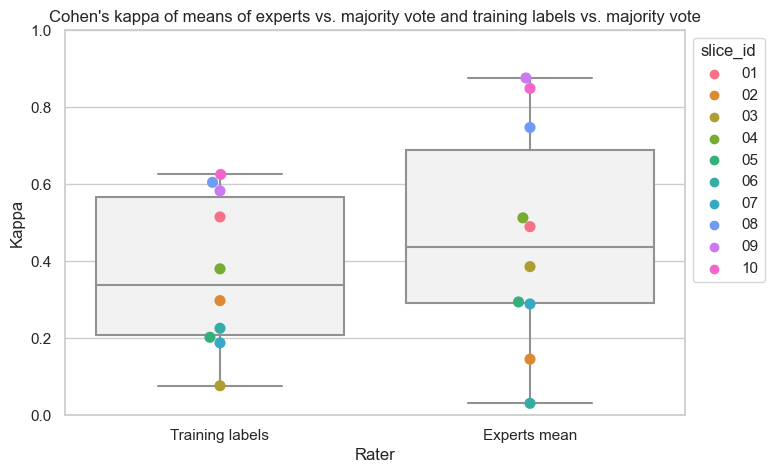

c:\Users\dotti\.conda\envs\sparks\lib\site-packages\seaborn\utils.py:456: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = old_legend.legendHandles


In [152]:
# plot average kappa score for each annotator (without gt) wrt majority vote
plt.figure(figsize=(8, 5))
sns.set_theme(style="whitegrid")

df_subset = majority_gt_df_with_mean[
    majority_gt_df_with_mean["Rater"].isin(["expert_mean", "ground_truth"])
]
ax = sns.boxplot(
    x="Rater",
    y="Kappa",
    data=df_subset,
    order=["ground_truth", "expert_mean"],
    color=".95",
)
ax = sns.swarmplot(
    x="Rater",
    y="Kappa",
    data=df_subset,
    order=["ground_truth", "expert_mean"],
    hue="slice_id",
    palette="husl",
    size=8,
)  # , color=".25", size=3)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

tick_labels = ["Training labels", "Experts mean"]
ax.set_xticklabels(tick_labels)

# set y axis limits
ax.set_ylim(0, 1)

plt.title(
    "Cohen's kappa of means of experts vs. majority vote and training labels vs. majority vote",
    fontsize=12,
)

plt.show()

# plot average kappa score for each annotator (including GT) wrt majority vote
plt.figure(figsize=(8, 5))
sns.set_theme(style="whitegrid")

df_subset = majority_gt_df_with_gt_with_mean[
    majority_gt_df_with_gt_with_mean["Rater"].isin(
        ["expert_mean_gt", "ground_truth"])
]
ax = sns.boxplot(
    x="Rater",
    y="Kappa",
    data=df_subset,
    order=["ground_truth", "expert_mean_gt"],
    color=".95",
)
ax = sns.swarmplot(
    x="Rater",
    y="Kappa",
    data=df_subset,
    order=["ground_truth", "expert_mean_gt"],
    hue="slice_id",
    palette="husl",
    size=8,
)  # , color=".25", size=3)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

tick_labels = ["Training labels", "Experts mean"]
ax.set_xticklabels(tick_labels)

# set y axis limits
ax.set_ylim(0, 1)

plt.title(
    "Cohen's kappa of means of experts vs. majority vote and training labels preds vs. majority vote",
    fontsize=12,
)

plt.show()

In [153]:
# concatenate dataframes containing ground_truth, expert_mean and expert_mean_gt
only_mean_df = pd.concat(
    [
        majority_gt_df_with_mean[
            majority_gt_df_with_mean["Rater"].isin(
                ["expert_mean", "ground_truth"])
        ],
        majority_gt_df_with_gt_with_mean[
            majority_gt_df_with_gt_with_mean["Rater"].isin(["expert_mean_gt"])
        ],
    ],
    ignore_index=True,
)

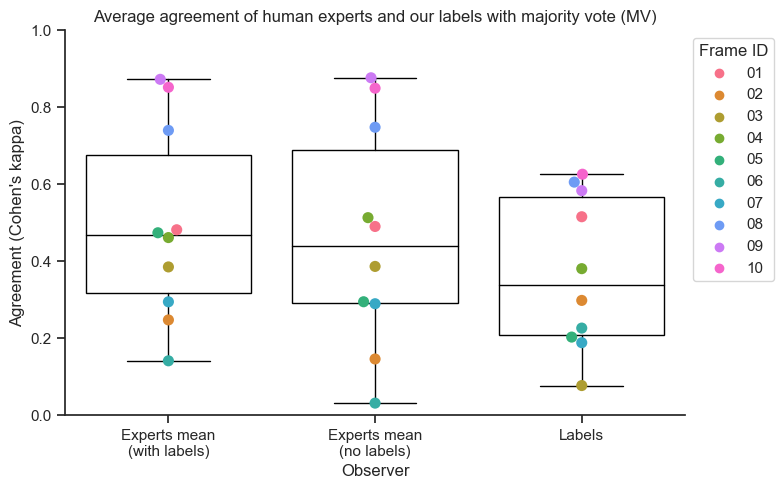

In [154]:
# set font size to 24
matplotlib.rcParams.update({"font.size": 22})

# set directory where plots will be saved
out_dir = r"C:\Users\dotti\OneDrive - Universitaet Bern\manuscript figures\annotated dataset validation"

# create palette where ground_truth is dark grey and all other experts are light grey
sns.set_color_codes()
pal = {
    rater: "darkgray" if rater == "ground_truth" else "lightgray"
    for rater in only_mean_df.Rater.unique()
}

# plot average kappa score for each annotator (without and with ground_truth) wrt majority vote
plt.figure(figsize=(8, 5))
sns.set_theme(style="ticks")

ax = sns.boxplot(
    x="Rater",
    y="Kappa",
    data=only_mean_df,
    order=["expert_mean_gt", "expert_mean", "ground_truth"],
    linewidth=1,
    **PROPS  # ,
    # color='.95', palette=pal
)
ax = sns.swarmplot(
    x="Rater",
    y="Kappa",
    data=only_mean_df,
    order=["expert_mean_gt", "expert_mean", "ground_truth"],
    hue="slice_id",
    palette="husl",
    size=8,
)  # , color=".25", size=3)

plt.legend(title="Frame ID", loc="upper left", bbox_to_anchor=(1, 1))

tick_labels = ["Experts mean\n(with labels)",
               "Experts mean\n(no labels)", "Labels"]
ax.set_xticklabels(tick_labels)

# set y axis limits
ax.set_ylim(0, 1)
ax.set(xlabel="Observer", ylabel="Agreement (Cohen's kappa)")

plt.title("Average agreement of human experts and our labels with majority vote (MV)")

plt.savefig(os.path.join(out_dir, "mean_kappa_majority_vote.svg"),
            transparent=True)

sns.despine()
plt.show()

In [89]:
# compute if unet_preds is non-inferior to expert_mean
tstat, pvalue = one_sided_non_inferiority_ttest(
    sample1=majority_df_pivot_t["expert_mean"],
    sample2=majority_df_pivot_t["unet_preds"],
    increase_is_desirable=True,
)

print("tstat (without unet preds): ", tstat)
print("pvalue (without unet preds): ", pvalue)

tstat_unet, pvalue_unet = one_sided_non_inferiority_ttest(
    sample1=majority_df_unet_pivot_t["expert_mean_unet"],
    sample2=majority_df_unet_pivot_t["unet_preds"],
    increase_is_desirable=True,
)

print("tstat (with unet preds): ", tstat_unet)
print("pvalue (with unet preds): ", pvalue_unet)

tstat (without unet preds):  0.32177747751491276
pvalue (without unet preds):  0.3774845714073384
tstat (with unet preds):  0.3826053831315862
pvalue (with unet preds):  0.3554457084928119


## Visualize sample frame and annotations

In [91]:
anon_ids

{'RJ': 'expert_0',
 'ME': 'expert_1',
 'EN': 'expert_2',
 'NS': 'expert_3',
 'MW': 'expert_4',
 'CS': 'expert_5'}

In [92]:
rater_ids = ["ground_truth", "unet_preds"] + list(anon_ids.values())
rater_ids

['ground_truth',
 'unet_preds',
 'expert_0',
 'expert_1',
 'expert_2',
 'expert_3',
 'expert_4',
 'expert_5']

In [93]:
slices_ids

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']

<>:92: DeprecationWarning: invalid escape sequence \s
<>:92: DeprecationWarning: invalid escape sequence \s
C:\Users\dotti\AppData\Local\Temp\ipykernel_9604\2989870379.py:92: DeprecationWarning: invalid escape sequence \s
  fig.savefig(save_path+f"\segmentation_sample_{sample_id}.svg", bbox_inches='tight', transparent=True, dpi=300)


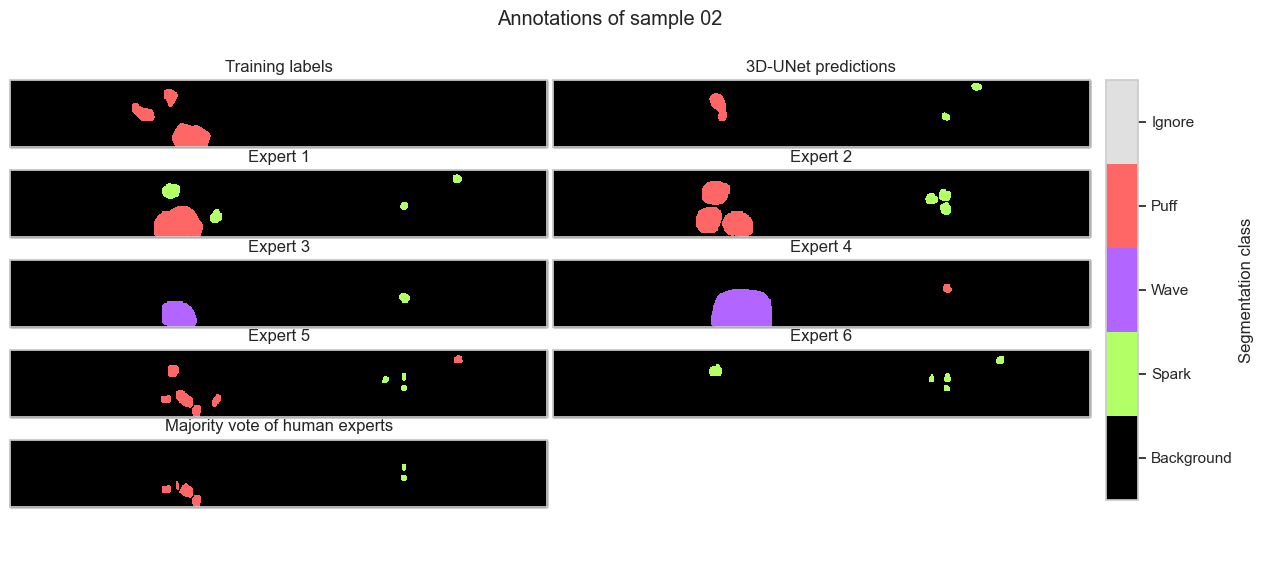

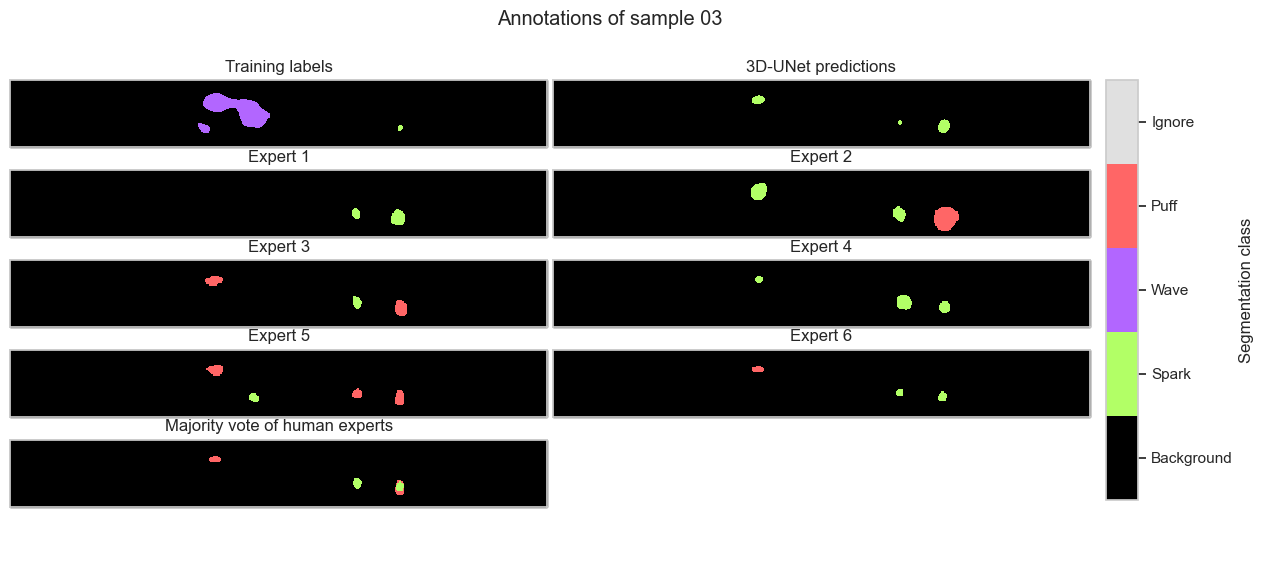

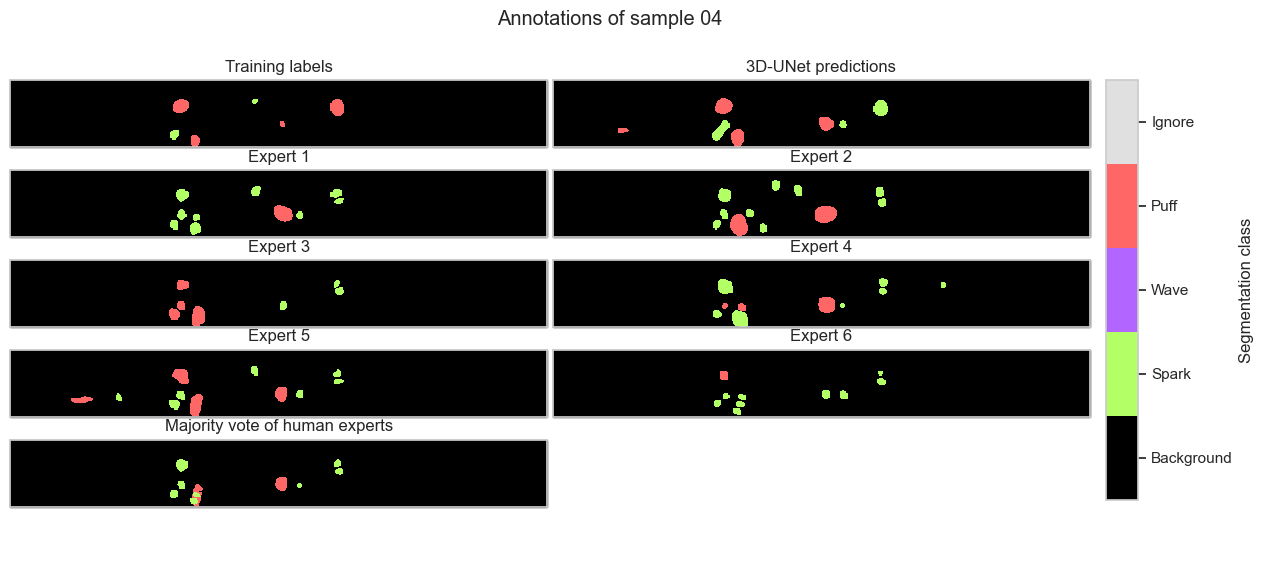

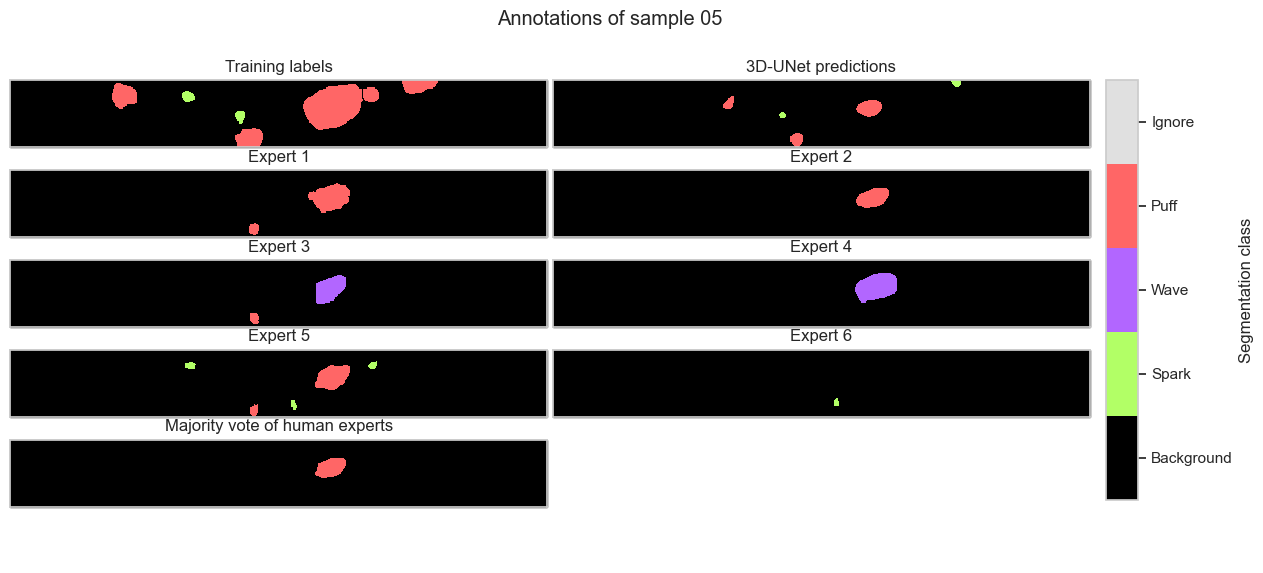

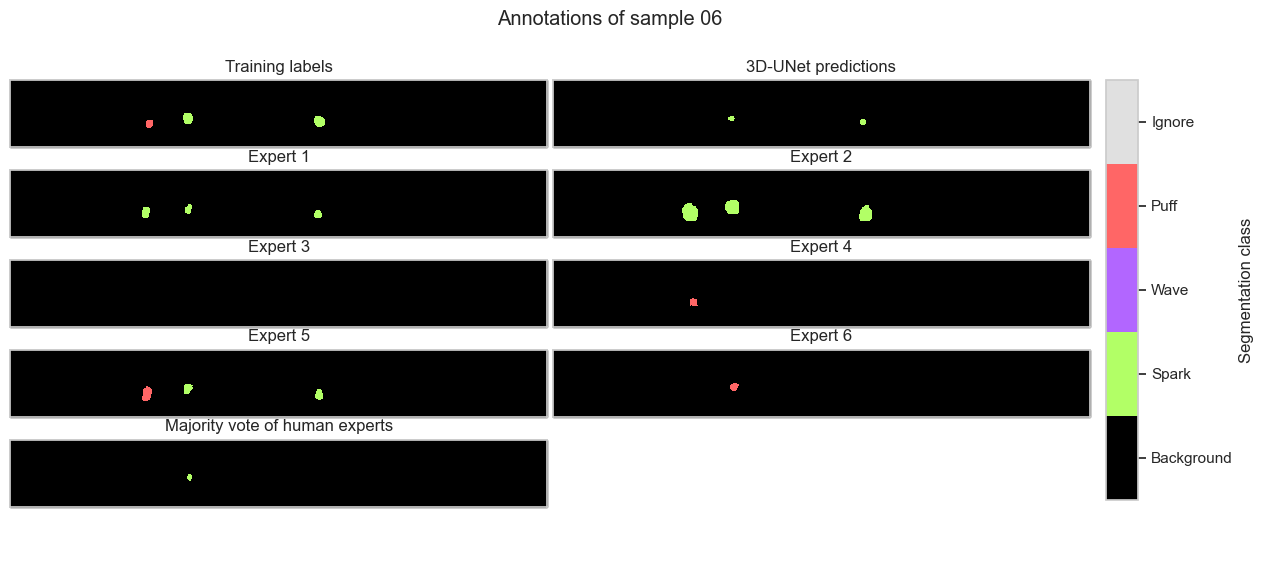

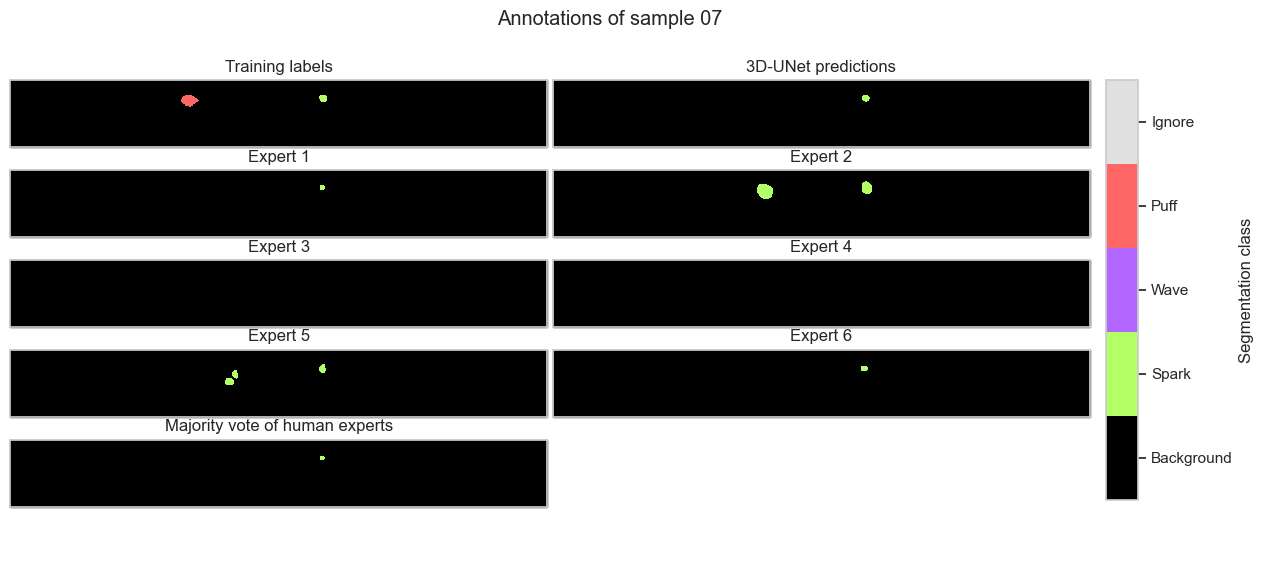

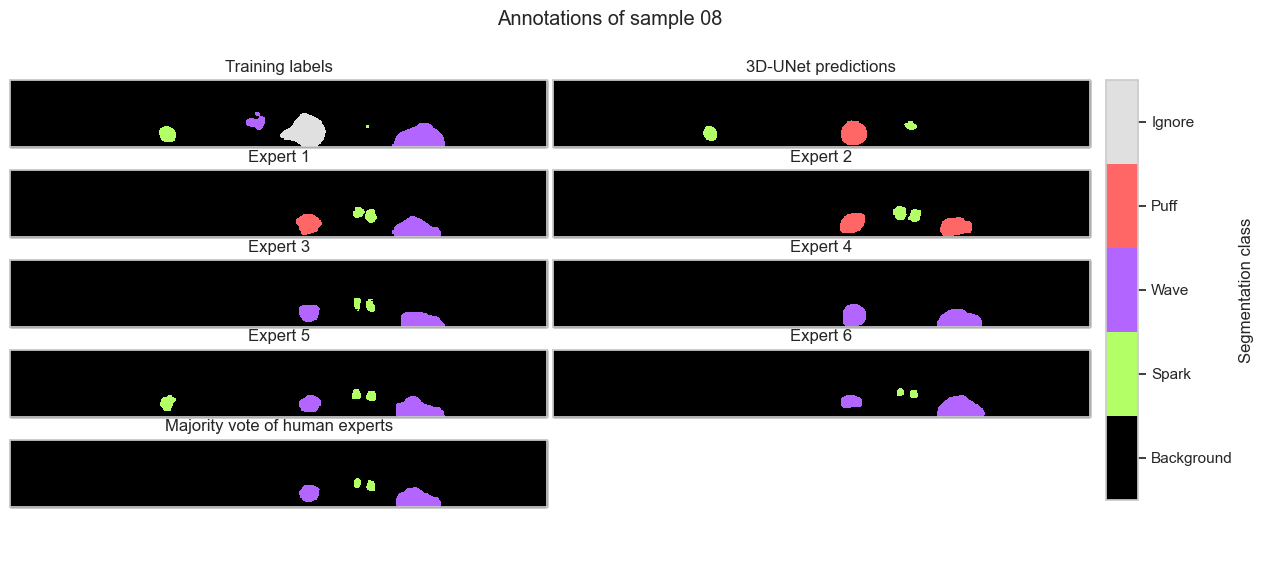

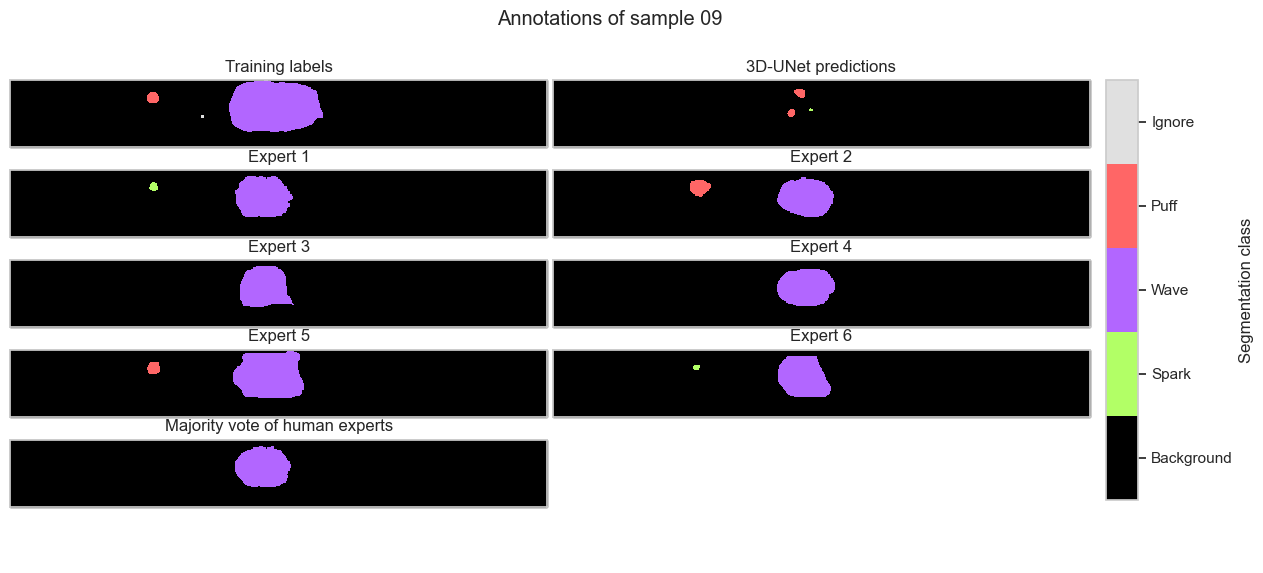

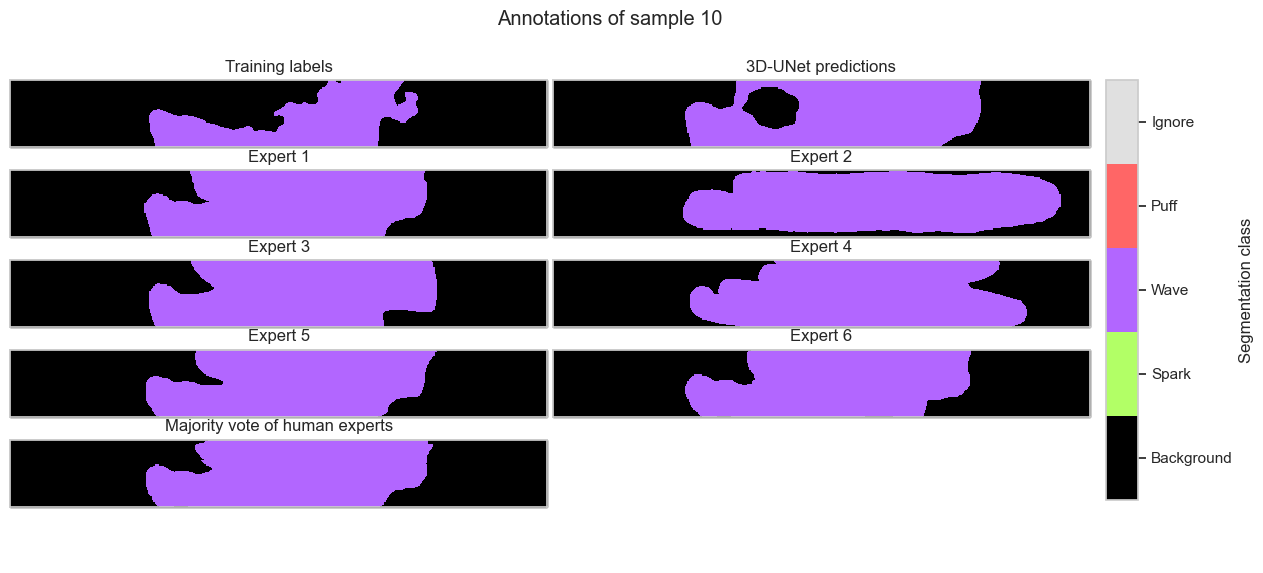

In [94]:
# define lower and upper bounds of data
data_min = 0
data_max = 4

# create cmap
green_spark = [178 / 255, 255 / 255, 102 / 255, 1]
red_puff = [255 / 255, 102 / 255, 102 / 255, 1]
purple_wave = [178 / 255, 102 / 255, 255 / 255, 1]
grey_ignore = [224 / 255, 224 / 255, 224 / 255, 1]
black = [0, 0, 0, 1]
colors = [black, green_spark, purple_wave, red_puff, grey_ignore]
cmap = ListedColormap(colors)

ncol = 2
nrow = math.ceil((len(rater_ids) + 1) / 2)

for sample_id in slices_ids:
    # create figure

    fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(16, 7))

    for i, ax in enumerate(axes.flat):
        if i < len(rater_ids):
            # show segmentation
            if rater_ids[i] == "ground_truth":
                ax.set_title("Training labels")
            elif rater_ids[i] == "unet_preds":
                ax.set_title("3D-UNet predictions")
            else:
                ax.set_title(f"Expert {i-1}")
            data = all_segmentations[rater_ids[i]][sample_id]
            im = ax.imshow(
                data,
                cmap=cmap,
                interpolation="nearest",
                vmin=data_min - 0.5,
                vmax=data_max + 0.5,
            )

            # add black border to subplot
            ax.patch.set_edgecolor("black")
            ax.patch.set_linewidth(1)

            # remove ticks from subplot
            ax.set_xticklabels([])
            ax.set_yticklabels([])

            # remove grid from subplot
            ax.grid(False)

            # print(f"{rater_ids[i]}: {np.unique(all_segmentations[rater_ids[i]][sample_id])}")
        elif i == len(rater_ids):
            # show majority vote
            ax.set_title("Majority vote of human experts")
            data = all_majority_votes[sample_id]["unet_preds"]
            im = ax.imshow(
                data,
                cmap=cmap,
                interpolation="nearest",
                vmin=data_min - 0.5,
                vmax=data_max + 0.5,
            )

            # add black border to subplot
            ax.patch.set_edgecolor("black")
            ax.patch.set_linewidth(1)

            # remove ticks from subplot
            ax.set_xticklabels([])
            ax.set_yticklabels([])

            # remove grid from subplot
            ax.grid(False)
        else:
            ax.axis("off")

    fig.subplots_adjust(right=0.8, hspace=-0.5, wspace=0.01)

    # position colorbar on the right side of the plot and tell the colorbar to tick at integers
    cbar_ax = fig.add_axes([0.81, 0.2, 0.02, 0.6])
    cbar = fig.colorbar(
        im,
        cax=cbar_ax,
        ticks=np.arange(data_min, data_max + 1),
        label="Segmentation class",
    )
    cbar.ax.set_yticklabels(["Background", "Spark", "Wave", "Puff", "Ignore"])

    fig.suptitle(f"Annotations of sample {sample_id}", y=0.9)  # , fontsize=24)

    plt.show()

    # save figure
    save_path = r"C:\Users\dotti\OneDrive - Universitaet Bern\manuscript figures\inter-rater variability"
    fig.savefig(
        save_path + f"\segmentation_sample_{sample_id}.svg",
        bbox_inches="tight",
        transparent=True,
        dpi=300,
    )

'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

### Majority vote

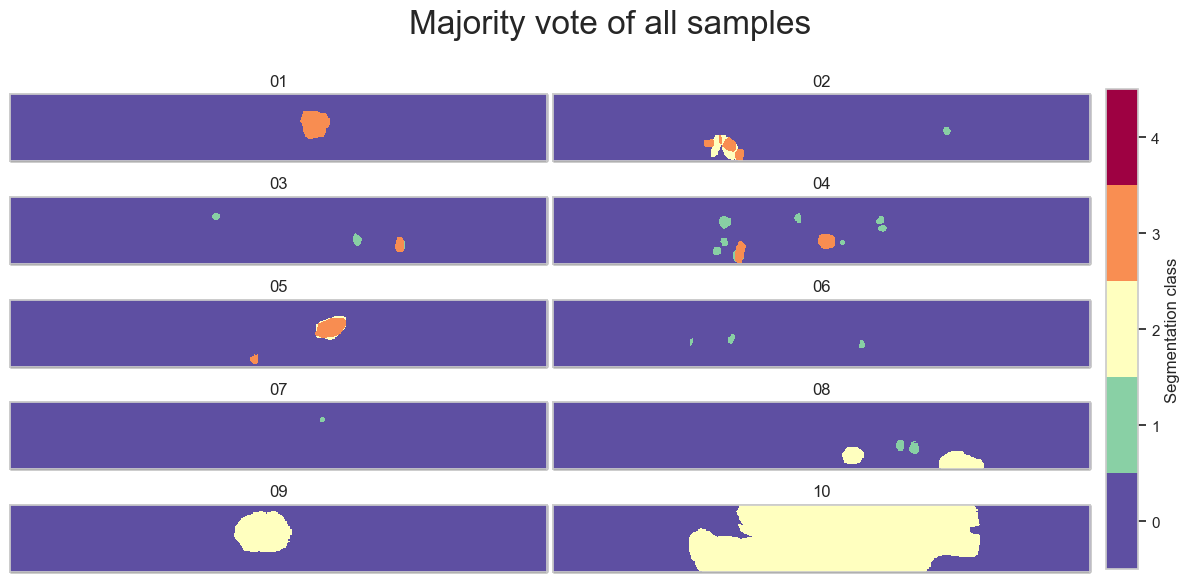

In [50]:
# define lower and upper bounds of data
data_min = 0
data_max = 4

# get colormap
cmap = plt.get_cmap("Spectral_r", data_max - data_min + 1)

ncol = 2
nrow = math.ceil(len(slices_ids) / 2)

fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(16, 8))

for i, ax in enumerate(axes.flat):
    # show majority vote segmentation
    ax.set_title(slices_ids[i])
    data = all_majority_votes[slices_ids[i]]["unet_preds"]
    im = ax.imshow(
        data,
        cmap=cmap,
        interpolation="nearest",
        vmin=data_min - 0.5,
        vmax=data_max + 0.5,
    )

    # add black border to subplot
    ax.patch.set_edgecolor("black")
    ax.patch.set_linewidth(1)

    # remove ticks from subplot
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # remove grid from subplot
    ax.grid(False)

fig.subplots_adjust(right=0.8, hspace=-0.5, wspace=0.01)

# position colorbar on the right side of the plot and tell the colorbar to tick at integers
cbar_ax = fig.add_axes([0.81, 0.2, 0.02, 0.6])
cbar = fig.colorbar(
    im, cax=cbar_ax, ticks=np.arange(data_min, data_max + 1), label="Segmentation class"
)

fig.suptitle(f"Majority vote of all samples", fontsize=24, y=0.9)

plt.show()

### Visualize original frames

In [51]:
# Load original frames
frames_dir = r"C:\Users\dotti\OneDrive - Universitaet Bern\inter-rater_variability\annotated_slices"

frames = {}
for sample_id in slices_ids:
    frame_id = slice_to_frame_id[sample_id] + 1
    frames[sample_id] = np.asarray(
        imageio.imread(
            frames_dir + f"\\sample{sample_id}_slice{frame_id:03}.tif")
    )

C:\Users\dotti\AppData\Local\Temp\ipykernel_5396\2737114704.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames[sample_id] = np.asarray(imageio.imread(frames_dir + f"\\sample{sample_id}_slice{frame_id:03}.tif"))
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: Type

<>:13: DeprecationWarning: invalid escape sequence \o
<>:13: DeprecationWarning: invalid escape sequence \o
C:\Users\dotti\AppData\Local\Temp\ipykernel_5396\1490251665.py:13: DeprecationWarning: invalid escape sequence \o
  fig.savefig(save_path+f"\original_frame_sample_{sample_id}.png", bbox_inches='tight')


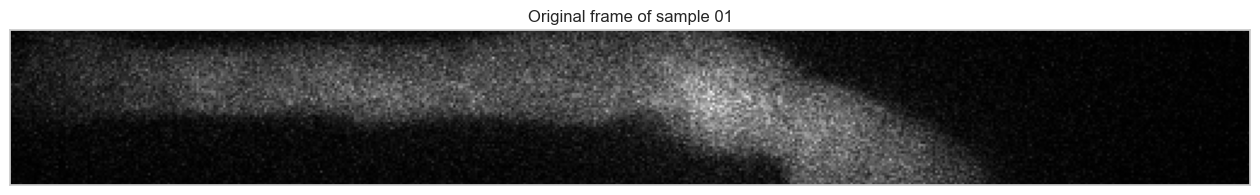

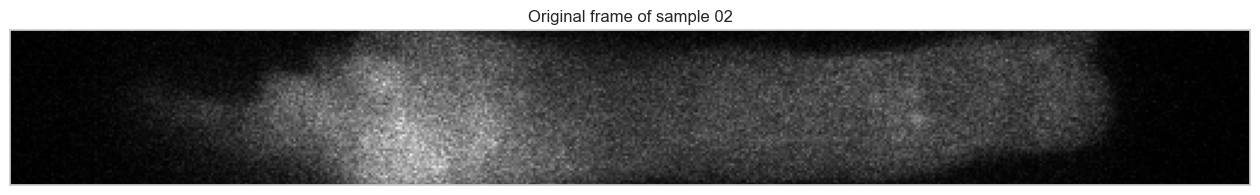

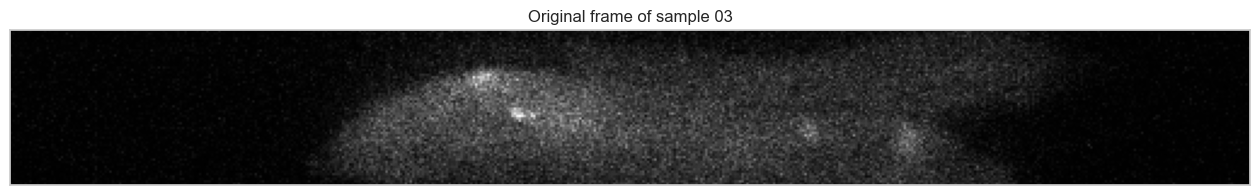

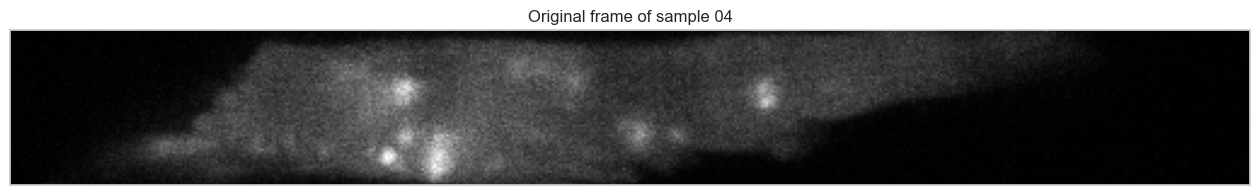

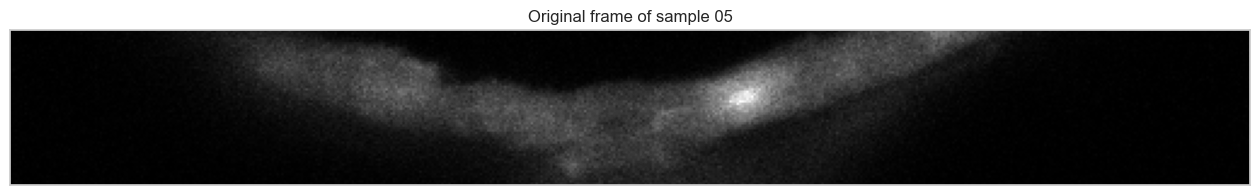

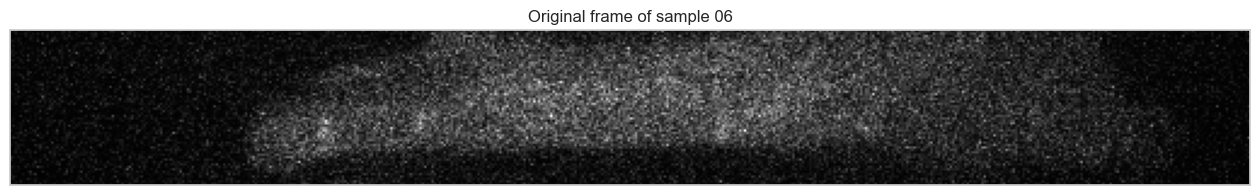

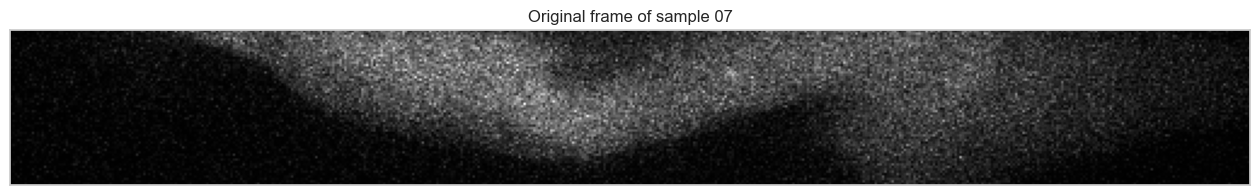

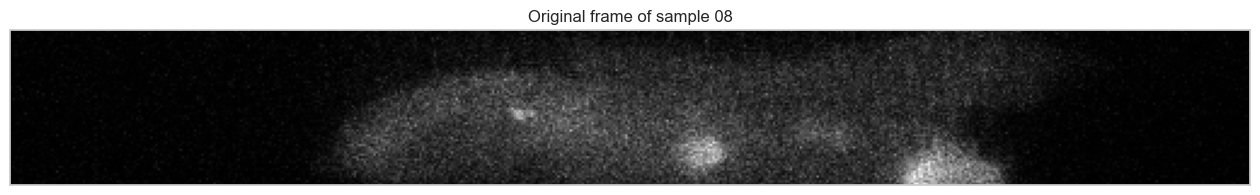

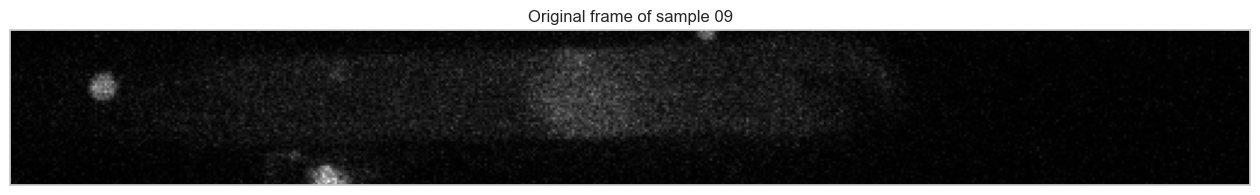

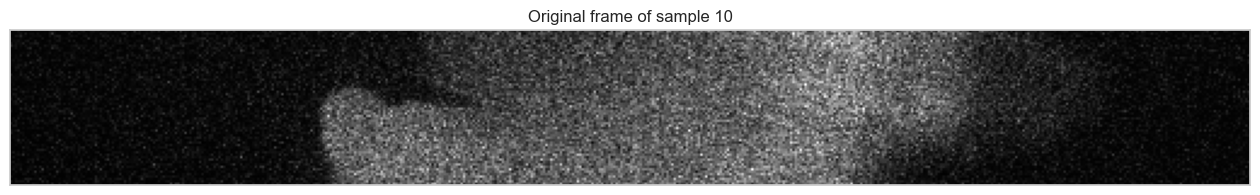

In [52]:
# plot original frames
for sample_id in slices_ids:
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.imshow(frames[sample_id], cmap="gray")
    ax.set_title(f"Original frame of sample {sample_id}")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)
    plt.show()

    # save original frames
    save_path = (
        r"C:\Users\dotti\OneDrive - Universitaet Bern\inter-rater_variability\figures"
    )
    fig.savefig(
        save_path + f"\original_frame_sample_{sample_id}.png", bbox_inches="tight"
    )

### Visualize all majority votes of a given frame

In [53]:
frame_id = "07"

expert_0: [0]
expert_1: [0]
expert_2: [0 1]
expert_3: [0 1]
expert_4: [0]
unet_preds: [0 1]


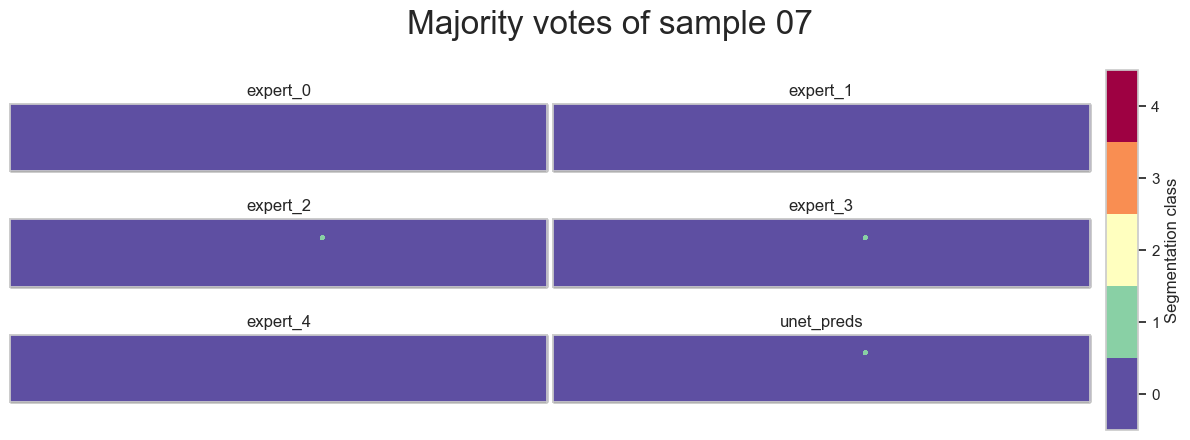

In [54]:
# define lower and upper bounds of data
data_min = 0
data_max = 4

# get colormap
cmap = plt.get_cmap("Spectral_r", data_max - data_min + 1)

# get list of raters for which majority vote is available
majority_rater_ids = list(all_majority_votes[frame_id].keys())

ncol = 2
nrow = math.ceil((len(majority_rater_ids)) / 2)

fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(16, 6))

for i, ax in enumerate(axes.flat):
    if i < len(majority_rater_ids):
        # show segmentation
        ax.set_title(majority_rater_ids[i])
        data = all_majority_votes[frame_id][majority_rater_ids[i]]
        im = ax.imshow(
            data,
            cmap=cmap,
            interpolation="nearest",
            vmin=data_min - 0.5,
            vmax=data_max + 0.5,
        )

        # add black border to subplot
        ax.patch.set_edgecolor("black")
        ax.patch.set_linewidth(1)

        # remove ticks from subplot
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        # remove grid from subplot
        ax.grid(False)

        print(f"{majority_rater_ids[i]}: {np.unique(data)}")
    else:
        ax.axis("off")

fig.subplots_adjust(right=0.8, hspace=-0.5, wspace=0.01)

# position colorbar on the right side of the plot and tell the colorbar to tick at integers
cbar_ax = fig.add_axes([0.81, 0.2, 0.02, 0.6])
cbar = fig.colorbar(
    im, cax=cbar_ax, ticks=np.arange(data_min, data_max + 1), label="Segmentation class"
)

fig.suptitle(f"Majority votes of sample {frame_id}", fontsize=24, y=0.9)

plt.show()

# save figure
# save_path = r"C:\Users\dotti\OneDrive - Universitaet Bern\inter-rater_variability\figures"
# fig.savefig(save_path+f"\segmentation_sample_{sample_id}.png", bbox_inches='tight')

In [55]:
np.unique(all_majority_votes[frame_id]["expert_1"])

array([0], dtype=uint16)